# Final Project | Prediction possibilities in a pandemic 
by Kevin Spurk

# Introduction

In this analysis I'm investigating the Covid 19 pandemic and have a look at the prediction opportunities of specific metrics such as the number of new daily cases and new daily deaths. The goal is to find out how well you can predict those metrics for a date in the future based on past and present data, comparing the prediction performance of two different datasets. One provides data of peoples movement patterns in areas such as retail, parks, public transport, etc. The other reflects search patterns of keywords connected to the pandemic and someone with a potential Covid infection experiencing symptoms might look for online. The I’m using data of 13 European countries to allow for a cross-country and a by-country analysis and prediction.

# Table of content

**1. Setup**

Importing libraries and datasets

**2. Data wrangling**

Initial elimination of  unnecessary features, data cleaning and wrangling.

**3. EDA**

Statistical and visual exploration of the data.

**4. Data Preprocessing**

Feature selection and using techniques like encoding and time lags to prepare the data for modeling.

**5. Baseline model**

Creating a first prediction model based on the mobility data and evaluate its performance to compare against further improvements and alternative model algorithms.

**6. Mobility data model improvements**

Developing the prediction model based on the mobility data. Applying feature transformations, using hyper parameter tuning and different model algorithms and comparing the results of different approaches.

**7. Google trends data model**

Developing the prediction model based on the search trends data equivalent to the previous step.

**8. Model insights**

A comparative summary of the modelling results


# 1 | Setup

### 1.1 Libary imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random
import datetime
import time
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.set_option('max_row', None)

### 1.2 Data imports

### 1.2.1. Google mobility trend data


In [2]:
# csv import
data_mob_global = pd.read_csv('data/mobility_google/Global_Mobility_Report.csv')

data_mob_global.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0


The google mobility dataset provides information about the movement patterns of people based to location data of Android mobile phones. The columns containing this information show the percentage difference Android user frequency compared to a baseline value (the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020) on a given day at a specific type of location. Locations are clustered into retail and recreation, grocery and pharmacy, parks, transit stations, workplace, residential. Columns for location and time data are also present. The dataset includes information of over 100 countries, and in parts regions of countries from February 2020 until November 2021.

The data is supposed to serve as a proxy for how populated these location clusters are, to find out if there is a statistically significant relationship between population and Covid 19 metrics and if you can build a prediction model with them in the coming steps.

In [3]:
data_mob_global.shape

(7697738, 15)

In [4]:
data_mob_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7697738 entries, 0 to 7697737
Data columns (total 15 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   country_region_code                                 object 
 1   country_region                                      object 
 2   sub_region_1                                        object 
 3   sub_region_2                                        object 
 4   metro_area                                          object 
 5   iso_3166_2_code                                     object 
 6   census_fips_code                                    float64
 7   place_id                                            object 
 8   date                                                object 
 9   retail_and_recreation_percent_change_from_baseline  float64
 10  grocery_and_pharmacy_percent_change_from_baseline   float64
 11  parks_percent_change_from_baseline   

### 1.2.2. google trends data

With the DeepL API I’m translating a list of 21 keywords connected to the pandemic into different language to check for there google search popularity in 13 European countries. I picked 21 keywords such as ‘covid’, ‘PCR’, ‘headache’ and other symptoms of SARS-CoV-2 under the assumption that an infected person experiencing symptoms would use them in a online search.

In [5]:
# import libaries to connect to google and deepL APIs 
from pytrends.request import TrendReq
from pytrends import dailydata
from translate import Translator 

# get authentification for deepL API
with open('auth/deepl_auth_key.txt') as f:
    deepl_auth_key = f.read()

# google trends API access request
pytrends = TrendReq(hl='en-US', tz=0)

In [6]:
from pyf.apis import deepl_translate_list
from pyf.imex import df_to_csv_format

# keyword list 
keywords_list = ['covid', 'corona', 'SARS-CoV-2', 'virus', 'symptoms', 'fever', 'cough', 'tiredness', 'loss of smell', 'throat', 'shortness of breath', 'breathing issues', 'headache', 'diarrhea', 'chest pain', 'PCR', 'corona test', 'covid test', 'test', 'sick', 'infection']

# dict of target countries and there languages 
countries_lang = {'GB': 'en', 'DE': 'de', 'FR': 'fr', 'NL': 'nl',
                  'ES': 'es', 'PT': 'pt', 'PL': 'pl', 'IT': 'it',
                  'AT': 'de', 'DK': 'da', 'SE': 'sv', 'GR': 'el',
                  'CZ': 'cs'}

# translating keyword list into target languages
c19_kw_dict, c19_kw_df = deepl_translate_list(auth=deepl_auth_key, keywords=keywords_list, lang_out=countries_lang)

# export translations to csv
# df_to_csv_format(c19_kw_df, 'keywords_translations', 'full')

# import translations
# c19_kw_df = pd.read_csv('data/multilanguage/keywords_translations_full.csv')


In [7]:
c19_kw_df

,GB,DE,FR,NL,ES,PT,PL,IT,AT,DK,SE,GR,CZ
0,covid,covid,covide,covid,covid,covid,covid,covid,covid,covid,covid,covid,covid
1,corona,corona,corona,corona,corona,corona,korona,corona,corona,corona,corona,corona,corona
2,SARS-CoV-2,SARS-CoV-2,SRAS-CoV-2,SARS-CoV-2,SARS-CoV-2,SRA-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
3,virus,Virus,virus,virus,virus,vírus,wirus,virus,Virus,virus,virus,ιός,virus
4,symptoms,Symptome,symptômes,symptomen,síntomas,sintomas,objawy,sintomi,Symptome,symptomer,symtom,συμπτώματα,příznaky
5,fever,Fieber,fièvre,koorts,fiebre,febre,gorączka,febbre,Fieber,feber,feber,πυρετός,horečka
6,cough,Husten,toux,hoest,toser,tosse,kaszel,tosse,Husten,hoste,hosta,βήχας,kašel
7,tiredness,Müdigkeit,fatigue,vermoeidheid,cansancio,cansaço,zmęczenie,stanchezza,Müdigkeit,træthed,trötthet,κούραση,únava
8,loss of smell,Geruchsverlust,la perte de l'odorat,verlies van reukzin,pérdida del olfato,perda do olfacto,utrata węchu,perdita dell'olfatto,Geruchsverlust,tab af lugt,förlust av lukt,απώλεια οσμής,ztráta čichu
9,throat,Kehle,gorge,keel,garganta,garganta,gardło,gola,Kehle,hals,hals,λαιμός,krk


Overview of the dictionary that holds the target countries with their respective keywords.

I use the google API to get data for the popularity of the keywords between march 2020 and October 2021.

In [8]:
from pyf.apis import g_trends_ml
import glob
from pyf.imex import import_concat_csv

# get google trends data for keywords in all languages
# data_g_trends = g_trends_ml(kw_dict=c19_kw_df, dt_start='2020-03', dt_end='2021-10', sleep_time=600)

# import google trends data from csv files
data_g_trends = import_concat_csv('data/keywords_google/', 'g_trend_2020-03_2021-10_GB')


In [9]:
data_g_trends.head(2)

,date,covid,corona,SARS-CoV-2,virus,symptoms,fever,cough,tiredness,loss of smell,throat,shortness of breath,breathing issues,headache,diarrhea,chest pain,PCR,corona test,covid test,test,sick,infection,location
0,2020-03-01,0.25,6.27,1.52,10.75,23.01,13.94,5.20,33.58,0.0,13.94,11.22,0.0,21.28,45.54,31.90,0.16,0.60,0.0,22.40,13.5,59.64,GB
1,2020-03-02,0.35,8.58,2.80,14.62,28.91,14.76,5.46,31.39,0.0,14.35,13.86,0.0,20.72,44.16,20.88,0.60,2.04,0.0,28.16,13.5,65.52,GB


In [10]:
data_g_trends.shape

(7930, 23)

The resulting dataframe gives a value for the daily keyword popularity in each country. The values range from 0 to 100 representing the highest search count over all keywords in that time period and all other search counts scaled to that value. The data fetched is from march 2020 until october 2021.

In the coming steps I’m exploring if there is a statistically significant relationship between keyword search popularity and Covid 19 metrics and if you can build a prediction model with them.


### 1.2.3. Covid-19 data

In [11]:
# csv import
owid_covid_data = pd.read_csv('data/covid19/owid-covid-data.csv')


In [12]:
owid_covid_data[owid_covid_data['location'] == 'Germany'].head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
44670,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,0.012,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44671,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,0.048,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN


This dataset provides various pandemic metrics by date and location, e.g. the number of people tested positive for a Sars-CoV-2 infection per day and accumulated, number of deaths associated with an infection also per day and accumulated, the rate of positive tests and more. It also comes with columns for dates and locations, show data from January 2020 until October 2021 for over 50 countries. This dataset is mostly going to serve as a selection of possible target variable for the prediction model.

In [13]:
owid_covid_data.shape

(132430, 65)

In [14]:
owid_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132430 entries, 0 to 132429
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   iso_code                                 132430 non-null  object 
 1   continent                                123969 non-null  object 
 2   location                                 132430 non-null  object 
 3   date                                     132430 non-null  object 
 4   total_cases                              125203 non-null  float64
 5   new_cases                                125201 non-null  float64
 6   new_cases_smoothed                       124158 non-null  float64
 7   total_deaths                             114094 non-null  float64
 8   new_deaths                               114290 non-null  float64
 9   new_deaths_smoothed                      124158 non-null  float64
 10  total_cases_per_million         

# 2 | Data wrangling

### 2.1. Google mobility trend data 

### 2.1.1. Feature elimination / subset selection

Target countries: United Kingdom, Germany, France, The Netherlands, Spain, Portugal, Poland, Italy, Austria, Denmark, Sweden, Greece and Czechia.

In [15]:
# dict of countries, country codes and there languages
tgt_countries = {'GB': ['en', 'united kingdom', 'GBR'], 'DE': ['de', 'germany', 'DEU'], 'FR': ['fr', 'france', 'FRA'], 'NL': ['nl', 'netherlands', 'NLD'],
                 'ES': ['es', 'spain', 'ESP'], 'PT': ['pt', 'portugal', 'PRT'], 'PL': ['pl', 'poland', 'POL'], 'IT': ['it', 'italy', 'ITA'],
                 'AT': ['de', 'austria', 'AUT'], 'DK': ['da', 'denmark', 'DNK'], 'SE': ['sv', 'sweden', 'SWE'], 'GR': ['el', 'greece', 'GRC'],
                 'CZ': ['cs', 'czechia', 'CZE']}


Keeping only the data for the target countries and only the columns with mobility trend values, country and date.

In [16]:
# getting subset of row with data of the target countries
countries_iso2 = [country_code for country_code in tgt_countries.keys()]
data_mobility = data_mob_global[data_mob_global['country_region_code'].isin(countries_iso2)]

# separating national data from regional data
data_mobility = data_mobility[data_mobility['sub_region_1'].isna()]

# dropping unneccessary columns
data_mobility = data_mobility.drop(data_mobility.iloc[:, 1:8], axis=1)


### 2.1.2. Data cleaning

In [17]:
# convert 'date' column to datetime
data_mobility['date'] = pd.to_datetime(data_mobility['date'], errors='coerce')
data_mobility['date'] = data_mobility['date'].dt.date

data_mobility['date'].isna().sum()

0

In [18]:
# clean column names 
data_mobility.columns = data_mobility.columns.str.replace('_percent_change_from_baseline', '')

# rename country_region_code column
g_mob_columns = list(data_mobility.columns.values)
g_mob_new_columns = {col:col for col in g_mob_columns}
g_mob_new_columns['country_region_code'] = 'location'

data_mobility = data_mobility.rename(columns=g_mob_new_columns)

# rename locations into iso3 format
for key, val in tgt_countries.items():
    for i in range(len(data_mobility)):
        if key == data_mobility['location'].iloc[i]:
            data_mobility['location'].iloc[i] = val[2]
            

I’m checking if there are no missing dates in the time period and the same number of dates for each country to make sure they are all represented equally. This way I want to avoid training the model on ‘imbalanced’ data, over- or underemphasising the data from certain countries in relation to others.

In [19]:
from pyf.preprocessing import timeframe_check_by_group, df_timeframe_limit, timeseries_interpolation_clustered, timeseries_clustered_sma, df_date_to_season
from pyf.preprocessing import value_overview

# check if range of dates is complete for all countries
mobility_timeframe = timeframe_check_by_group(df=data_mobility, groupby='location', timeframe='date')

timeframe: 2020-02-15 - 2021-11-17 
 no. of dates: 642 
 timeframe complete!


In order to match features and targets later on and moreover have a fair prediction comparison between the 2 feature sets, I’m restricting this data - like the other datasets later on as well - to a time period from march 1, 2020 to October 31, 2021.  

In [20]:
# picking only df entries between Mar 2020 and Oct 2021
data_mobility = df_timeframe_limit(data_mobility, 'date', '2020-03-01', '2021-10-31')

mobility_timeframe = timeframe_check_by_group(df=data_mobility, groupby='location', timeframe='date')


timeframe: 2020-03-01 - 2021-10-31 
 no. of dates: 610 
 timeframe complete!


### 2.1.3. Null values

Overview to check for values that have to be replaced, displaying null values, zeros and negative values in the data.

In [21]:
g_mob_ov, g_mob_columns = value_overview(df=data_mobility, neg_allowed=True)

In [22]:
g_mob_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
location,object,13,0,0.00,0,0.0,0,0.00,0,0.00
date,object,610,0,0.00,0,0.0,0,0.00,0,0.00
retail_and_recreation,float64,142,0,0.00,0,0.0,156,1.97,6199,78.17
grocery_and_pharmacy,float64,203,1,0.01,0,0.0,273,3.44,3638,45.88
parks,float64,449,0,0.00,0,0.0,48,0.61,2028,25.57
transit_stations,float64,139,0,0.00,0,0.0,73,0.92,7306,92.13
workplaces,float64,116,0,0.00,0,0.0,89,1.12,7161,90.30
residential,float64,54,0,0.00,0,0.0,402,5.07,913,11.51


Since zeros and negative values are regular values in the context of this data, there is no action necessary, besides replacing one null value by interpolation. In a time series interpolation is in most cases the best approach, since it is very likely to be more sound estimate than those produced by other methods.

In [23]:
# interpolating null values
data_mobility = timeseries_interpolation_clustered(df=data_mobility, timeframe='date', cluster_by='location', method='polynomial', order=2)


In [24]:
data_mobility.isna().sum()

location                 0
date                     0
retail_and_recreation    0
grocery_and_pharmacy     0
parks                    0
transit_stations         0
workplaces               0
residential              0
dtype: int64

### 2.1.4. Feature additions

I add columns for the season of the year to the dataset and create a alternative version of the data  contains a simple moving average for the last 5 days instead of the daily values to account for the fact that the mobility patterns of people over that period might have better predictive capability than daily values. The performance of the two variations is later on compared.

In [25]:
# add season column
data_mobility = df_date_to_season(data_mobility, 'date')

# creating a df with simple moving averages (5 days) of features
data_mobility_sma = timeseries_clustered_sma(df=data_mobility, cluster_by='location', timeframe='date', nod=5, drop_original=True)

# interpolation of NaNs in first 4 days in sma columns
data_mobility_sma = timeseries_interpolation_clustered(df=data_mobility_sma, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [26]:
data_mobility_sma.head(2)

,location,date,season,retail_and_recreation_sma_5d,grocery_and_pharmacy_sma_5d,parks_sma_5d,transit_stations_sma_5d,workplaces_sma_5d,residential_sma_5d
0,AUT,2020-03-01,spring,0.8,5.2,7.4,-0.2,2.0,0.0
1,AUT,2020-03-02,spring,0.8,5.2,7.4,-0.2,2.0,0.0


In [27]:
data_mobility_sma.isna().sum()

location                        0
date                            0
season                          0
retail_and_recreation_sma_5d    0
grocery_and_pharmacy_sma_5d     0
parks_sma_5d                    0
transit_stations_sma_5d         0
workplaces_sma_5d               0
residential_sma_5d              0
dtype: int64

In [165]:
for c in data_mobility.select_dtypes(np.number).columns:
    print(c)
    print(max(data_mobility[c]))
    print(min(data_mobility[c]))
    print(data_mobility[c].mean())
    
data_mobility[data_mobility['residential'] == max(data_mobility['residential'])]

retail_and_recreation
60.0
-96.0
-21.925725094577555
grocery_and_pharmacy
199.0
-94.0
1.2303844238859083
parks
421.0
-91.0
53.62547288776797
transit_stations
59.0
-92.0
-28.999117276166455
workplaces
34.0
-90.0
-24.65081967213115
residential
46.0
-10.0
7.252711223203026


,location,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,season
6750,PRT,2020-04-10,-81.0,-45.0,-70.0,-85.0,-84.0,46.0,spring


### 2.2. Google trends data

### 2.2.1. Data cleaning

In [28]:
# convert 'date' column to datetime
data_g_trends['date'] = pd.to_datetime(data_g_trends['date'], errors='coerce')
data_g_trends['date'] = data_g_trends['date'].dt.date

data_g_trends['date'].isna().sum()

0

In [29]:
from pyf.preprocessing import clean_headers

# clean column names 
data_g_trends = clean_headers(data_g_trends)

# rename locations into iso3 format
for key, val in tgt_countries.items():
    for i in range(len(data_g_trends)):
        if key == data_g_trends['location'].iloc[i]:
            data_g_trends['location'].iloc[i] = val[2]
            

In [30]:
# check if range of dates is complete for all countries
g_trends_timeframe = timeframe_check_by_group(df=data_g_trends, groupby='location', timeframe='date')


timeframe: 2020-03-01 - 2021-10-31 
 no. of dates: 610 
 timeframe complete!


### 2.2.2. Null values

In [31]:
g_trends_ov, g_trends_columns = value_overview(df=data_g_trends, neg_allowed=False)

In [32]:
g_trends_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
date,object,610,0,0.00,0,0.0,0,0.00,0,0.0
covid,float64,2302,0,0.00,0,0.0,57,0.72,0,0.0
corona,float64,1658,0,0.00,0,0.0,12,0.15,0,0.0
sars-cov-2,float64,1346,1035,13.05,0,0.0,3806,47.99,0,0.0
virus,float64,1031,0,0.00,0,0.0,666,8.40,0,0.0
symptoms,float64,1672,0,0.00,0,0.0,0,0.00,0,0.0
fever,float64,1709,0,0.00,0,0.0,572,7.21,0,0.0
cough,float64,1809,0,0.00,0,0.0,983,12.40,0,0.0
tiredness,float64,2145,31,0.39,0,0.0,1460,18.41,0,0.0
loss_of_smell,float64,720,4577,57.72,0,0.0,2065,26.04,0,0.0


The data contains a high amount of null values and zeros, which are in many cases also cause by the fetching limitations of the google API. I’m removing features with an amount of null values higher then 20 percent or more then 30 percent zeros. For the remaining columns I’m removing null values with interpolation. I apply two interpolations because the null values at the beginning have to be dealt with using a different interpolation method.

In [36]:
# dropping columns with too many nulls
data_g_trends = data_g_trends.drop(['sars-cov-2', 'loss_of_smell', 'shortness_of_breath', 'breathing_issues', 'diarrhea', 'corona_test', 'covid_test'], axis=1)

# interpolating null values
data_g_trends = timeseries_interpolation_clustered(df=data_g_trends, timeframe='date', cluster_by='location', method='polynomial', order=2)
data_g_trends = timeseries_interpolation_clustered(df=data_g_trends, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')
data_g_trends = timeseries_interpolation_clustered(df=data_g_trends, timeframe='date', cluster_by='location', method='ffill', limit_direction='forward')

data_g_trends.isna().sum()


date                      0
covid                     0
corona                    0
sars-cov-2              610
virus                     0
symptoms                  0
fever                     0
cough                     0
tiredness                 0
loss_of_smell          3660
throat                    0
shortness_of_breath     610
breathing_issues       1220
headache                  0
diarrhea                610
chest_pain                0
pcr                       0
corona_test            2440
covid_test             1830
test                      0
sick                      0
infection                 0
location                  0
dtype: int64

I'm going to proceed with the features seen above.

### 2.2.3. Feature additions

In [38]:
# add season column
data_g_trends = df_date_to_season(data_g_trends, 'date')

# creating a df with simple moving averages (5 days) of features
data_g_trends_sma = timeseries_clustered_sma(df=data_g_trends, cluster_by='location', timeframe='date', nod=5, drop_original=True)

# interpolation of NaNs in first 4 days in sma columns
data_g_trends_sma = timeseries_interpolation_clustered(df=data_g_trends_sma, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [39]:
data_g_trends_sma.head(2)

,date,location,season,covid_sma_5d,corona_sma_5d,virus_sma_5d,symptoms_sma_5d,fever_sma_5d,cough_sma_5d,tiredness_sma_5d,throat_sma_5d,headache_sma_5d,chest_pain_sma_5d,pcr_sma_5d,test_sma_5d,sick_sma_5d,infection_sma_5d
0,2020-03-01,GBR,spring,0.39,9.372,15.394,28.084,12.874,5.408,38.544,14.432,22.736,24.128,0.5,27.072,15.84,63.504
1,2020-03-02,GBR,spring,0.39,9.372,15.394,28.084,12.874,5.408,38.544,14.432,22.736,24.128,0.5,27.072,15.84,63.504


### 2.3. Covid-19 data

### 2.3.1 Feature elimination / subset selection

In [40]:
# getting subset of row with data of the target countries
countries_iso3 = [cn[2] for cn in tgt_countries.values()]
data_c19 = owid_covid_data[owid_covid_data['iso_code'].isin(countries_iso3)]

# dropping unneccessary columns
data_c19 = data_c19[['iso_code', 'date', 'new_cases_smoothed', 
                     'new_deaths_smoothed', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                     'icu_patients', 'icu_patients_per_million', 'hosp_patients', 
                     'hosp_patients_per_million', 'positive_rate']]

# convert 'date' column to datetime
data_c19['date'] = pd.to_datetime(data_c19['date'], errors='coerce')
data_c19['date'] = data_c19['date'].dt.date

data_c19['date'].isna().sum()


0

### 2.3.2. Data cleaning

In [41]:
# rename column iso_code
c19_columns = list(data_c19.columns.values)
c19_new_columns = {col:col for col in c19_columns}
c19_new_columns['iso_code'] = 'location'

data_c19 = data_c19.rename(columns=c19_new_columns)

In [42]:
# check if range of dates is complete for all countries
c19_timeframe = timeframe_check_by_group(df=data_c19, groupby='location', timeframe='date')


timeframe incomplete. Check details.


In [43]:
c19_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-02-25,2021-11-10,625,650
1,CZE,2020-01-06,2021-11-10,627,650
2,DNK,2020-02-02,2021-11-10,648,650
3,FRA,2020-01-24,2021-11-10,657,650
4,DEU,2020-01-27,2021-11-10,654,650
5,GRC,2020-01-06,2021-11-10,631,650
6,ITA,2020-01-31,2021-11-10,650,650
7,NLD,2020-02-27,2021-11-10,623,650
8,POL,2020-03-04,2021-11-10,617,650
9,PRT,2020-01-06,2021-11-10,631,650


In [44]:
# picking only df entries between Mar 2020 and Oct 2021
data_c19 = df_timeframe_limit(data_c19, 'date', '2020-03-01', '2021-10-31')

c19_timeframe = timeframe_check_by_group(df=data_c19, groupby='location', timeframe='date')


timeframe incomplete. Check details.


In [45]:
c19_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-03-01,2021-10-31,610,610
1,CZE,2020-03-01,2021-10-31,610,610
2,DNK,2020-03-01,2021-10-31,610,610
3,FRA,2020-03-01,2021-10-31,610,610
4,DEU,2020-03-01,2021-10-31,610,610
5,GRC,2020-03-01,2021-10-31,610,610
6,ITA,2020-03-01,2021-10-31,610,610
7,NLD,2020-03-01,2021-10-31,610,610
8,POL,2020-03-04,2021-10-31,607,610
9,PRT,2020-03-01,2021-10-31,610,610


In [46]:
c19_ov, c19_columns = value_overview(df=data_c19, neg_allowed=False)

In [47]:
c19_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
location,object,13,0,0.00,0,0.0,0,0.00,0,0.00
date,object,610,0,0.00,0,0.0,0,0.00,0,0.00
new_cases_smoothed,float64,6695,21,0.26,0,0.0,0,0.00,11,0.14
new_deaths_smoothed,float64,2111,21,0.26,0,0.0,110,1.39,28,0.35
new_cases_smoothed_per_million,float64,7279,21,0.26,0,0.0,0,0.00,11,0.14
new_deaths_smoothed_per_million,float64,3515,21,0.26,0,0.0,110,1.39,28,0.35
icu_patients,float64,2230,1643,20.73,0,0.0,43,0.54,0,0.00
icu_patients_per_million,float64,3994,1643,20.73,0,0.0,43,0.54,0,0.00
hosp_patients,float64,3887,1680,21.19,0,0.0,14,0.18,0,0.00
hosp_patients_per_million,float64,5189,1680,21.19,0,0.0,14,0.18,0,0.00


In [48]:
from pyf.preprocessing import complete_timeseries

# adding dates to data from loc 'POL' to have the same dates for all loc
data_pol = data_c19[data_c19['location'] == 'POL']

data_pol = complete_timeseries(df=data_pol, timeframe='date', start_date='2020 03 01', end_date='2021 10 31', constant_col=['location'])

# concating original df and new data for loc 'POL'
data_c19 = data_c19[data_c19['location'] != 'POL']
data_c19 = pd.concat([data_c19, data_pol], axis=0)


In [49]:
data_c19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7930 entries, 7462 to 609
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location                         7930 non-null   object 
 1   date                             7930 non-null   object 
 2   new_cases_smoothed               7906 non-null   float64
 3   new_deaths_smoothed              7906 non-null   float64
 4   new_cases_smoothed_per_million   7906 non-null   float64
 5   new_deaths_smoothed_per_million  7906 non-null   float64
 6   icu_patients                     6284 non-null   float64
 7   icu_patients_per_million         6284 non-null   float64
 8   hosp_patients                    6247 non-null   float64
 9   hosp_patients_per_million        6247 non-null   float64
 10  positive_rate                    5955 non-null   float64
dtypes: float64(9), object(2)
memory usage: 743.4+ KB


### 2.3.3. Handling null values

In [50]:
data_c19[data_c19['new_cases_smoothed'].isna()]
# data_c19[data_c19['new_cases_smoothed_per_million'].isna()]
# data_c19[data_c19['new_deaths_smoothed'].isna()]
# data_c19[data_c19['new_deaths_smoothed_per_million'].isna()]

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
30312,CZE,2020-03-01,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30313,CZE,2020-03-02,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30314,CZE,2020-03-03,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30315,CZE,2020-03-04,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30316,CZE,2020-03-05,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
31570,DNK,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31571,DNK,2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46246,GRC,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84193,NLD,2020-03-01,NaN,NaN,NaN,NaN,11.0,0.641,20.0,1.165,NaN
84194,NLD,2020-03-02,NaN,NaN,NaN,NaN,10.0,0.582,34.0,1.980,NaN


In [51]:
data_c19[data_c19['new_cases_smoothed'] < 0]
# data_c19[data_c19['new_cases_smoothed_per_million'] < 0]
# data_c19[data_c19['new_deaths_smoothed'] < 0]
# data_c19[data_c19['new_deaths_smoothed_per_million'] < 0]

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
41979,FRA,2020-04-07,-698.000,972.000,-10.331,14.386,7004.0,103.664,29871.0,442.113,NaN
41980,FRA,2020-04-08,-839.286,870.714,-12.422,12.887,7019.0,103.886,30217.0,447.234,NaN
41981,FRA,2020-04-09,-599.000,975.143,-8.866,14.433,6937.0,102.673,30608.0,453.021,NaN
41982,FRA,2020-04-10,-1121.714,955.571,-16.602,14.143,6875.0,101.755,31108.0,460.421,NaN
111924,ESP,2021-03-02,-4464.000,246.000,-95.496,5.263,2796.0,59.814,11246.0,240.581,NaN
111925,ESP,2021-03-03,-4903.286,254.143,-104.894,5.437,2709.0,57.952,10788.0,230.783,NaN
111926,ESP,2021-03-04,-5407.714,241.143,-115.685,5.159,2615.0,55.942,10200.0,218.204,NaN
111927,ESP,2021-03-05,-5648.714,285.143,-120.840,6.100,2571.0,55.000,9896.0,211.701,NaN
111928,ESP,2021-03-06,-5648.714,285.143,-120.840,6.100,NaN,NaN,NaN,NaN,NaN
111929,ESP,2021-03-07,-5648.714,285.143,-120.840,6.100,NaN,NaN,NaN,NaN,NaN


Interpolation is the most valid method of dealing with null values. It's not going to produce good estimates in all cases, since many null values are consequtive and occure at the beginning of the time series. Negative values are treated as null values too.

In [52]:
# set negaitve values as null for interpolation
for col in data_c19.select_dtypes(np.number).columns:
    for i in range(len(data_c19)):
        if data_c19[col].iloc[i] < 0:
            data_c19[col].iloc[i] = np.NaN

# interpolating null values for all loc
c19_full = timeseries_interpolation_clustered(df=data_c19, timeframe='date', cluster_by='location', method='polynomial', order=2)
c19_full = timeseries_interpolation_clustered(df=c19_full, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [53]:
c19_full.isna().sum()

location                              0
date                                  0
new_cases_smoothed                    0
new_deaths_smoothed                   0
new_cases_smoothed_per_million        0
new_deaths_smoothed_per_million       0
icu_patients                       1222
icu_patients_per_million           1222
hosp_patients                      1222
hosp_patients_per_million          1222
positive_rate                         3
dtype: int64

### 2.3.4. Feature additions

In [54]:
from pyf.preprocessing import timeseries_clustered_moving_sum

# add column with moving sums (last 5 days) for new cases per million 
c19_full = timeseries_clustered_moving_sum(df=c19_full, cluster_by='location', timeframe='date', nod=5, columns=['new_cases_smoothed_per_million'])

# interpolation of NaNs in first 4 days in moving sums columns
c19_full = timeseries_interpolation_clustered(df=c19_full, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [55]:
c19_full.head(2)

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate,new_cases_smoothed_per_million_sum_5d
0,AUT,2020-03-01,2.000,0.0,0.221,0.0,215.0,23.775,856.0,94.658,0.014,1.832
1,AUT,2020-03-02,2.571,0.0,0.284,0.0,215.0,23.775,856.0,94.658,0.014,1.832


In [56]:
# from pyf.preprocessing import timeseries_plot

# plot_pol = timeseries_plot(data_c19, 'date', 'location', 'DEU')

### 2.4. combining features and targets

In [57]:
from pyf.preprocessing import merge_features_targets

target_list = ['new_cases_smoothed', 'new_deaths_smoothed', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'date', 'location']

# using moving sum of cases as a feature
mobility = pd.merge(data_mobility, c19_full[['date', 'location', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])
mobility_sma = pd.merge(data_mobility_sma, c19_full[['date', 'location', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])

trends = pd.merge(data_g_trends, c19_full[['date', 'location', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])
trends_sma = pd.merge(data_g_trends_sma, c19_full[['date', 'location', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])

# dropping moving sum from target df
c19_full = c19_full.drop(['new_cases_smoothed_per_million_sum_5d'], axis=1)

# feature datasets with target variables
mobility = merge_features_targets(df=mobility, targets=c19_full, in_columns=target_list, timeframe='date', on=['date', 'location'])
mobility_sma = merge_features_targets(df=mobility_sma, targets=c19_full, in_columns=target_list, timeframe='date', on=['date', 'location'])

trends = merge_features_targets(df=trends, targets=c19_full, in_columns=target_list, timeframe='date', on=['date', 'location'])
trends_sma = merge_features_targets(df=trends_sma, targets=c19_full, in_columns=target_list, timeframe='date', on=['date', 'location'])


In [58]:
mobility['new_cases_smoothed'].head(2)

,location,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,season,new_cases_smoothed_per_million_sum_5d,new_cases_smoothed
0,AUT,2020-03-01,0.0,8.0,6.0,1.0,2.0,0.0,spring,1.832,2.000
1,AUT,2020-03-02,2.0,6.0,16.0,1.0,3.0,-1.0,spring,1.832,2.571


In [59]:
trends['new_deaths_smoothed'].head(2)

,date,covid,corona,virus,symptoms,fever,cough,tiredness,throat,headache,chest_pain,pcr,test,sick,infection,location,season,new_cases_smoothed_per_million_sum_5d,new_deaths_smoothed
0,2020-03-01,0.25,6.27,10.75,23.01,13.94,5.20,33.58,13.94,21.28,31.90,0.16,22.40,13.5,59.64,GBR,spring,1.645,0.0
1,2020-03-02,0.35,8.58,14.62,28.91,14.76,5.46,31.39,14.35,20.72,20.88,0.60,28.16,13.5,65.52,GBR,spring,1.645,0.0


# 3 | EDA

### 3.1. Overview of numerical features

### 3.1.1. Covid 19 data

In [60]:
c19_full.describe().T

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed,7930.0,5303.035493,8266.951583,-4569.717705,435.60675,1767.7855,6274.142750,59828.571
new_deaths_smoothed,7930.0,96.518942,168.849089,-0.424118,4.71400,22.6425,98.678250,1253.000
new_cases_smoothed_per_million,7930.0,164.231330,197.125891,-67.635324,21.63600,85.5520,234.673750,1267.768
new_deaths_smoothed_per_million,7930.0,2.717350,3.785582,-0.041134,0.25800,0.9690,3.796167,28.605
icu_patients,6708.0,894.129775,1247.676568,0.000000,74.00000,358.0000,1127.000000,7019.000
icu_patients_per_million,6708.0,23.567623,25.470492,0.000000,4.86300,13.7120,36.008250,192.642
hosp_patients,6708.0,5636.518626,8405.121163,-3734.083000,358.75000,1728.5000,6896.250000,39254.000
hosp_patients_per_million,6708.0,146.904697,170.189617,-55.267370,27.47050,81.4210,200.160500,922.401
positive_rate,7927.0,0.057197,0.070247,0.000000,0.01400,0.0310,0.076274,0.503


### 3.1.2. Google mobility data

In [61]:
data_mobility.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,7930.0,-21.925725,26.194778,-96.0,-40.0,-17.0,-2.0,60.0
grocery_and_pharmacy,7930.0,1.230384,22.120941,-94.0,-7.0,1.0,11.0,199.0
parks,7930.0,53.625473,76.224223,-91.0,-1.0,38.0,93.0,421.0
transit_stations,7930.0,-28.999117,21.193417,-92.0,-43.0,-29.0,-14.0,59.0
workplaces,7930.0,-24.650820,18.729544,-90.0,-34.0,-24.0,-13.0,34.0
residential,7930.0,7.252711,7.553714,-10.0,2.0,6.0,11.0,46.0


In [62]:
data_mobility_sma.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation_sma_5d,7930.0,-21.922320,25.047174,-93.0,-40.0,-17.0,-2.40,36.2
grocery_and_pharmacy_sma_5d,7930.0,1.157497,17.393318,-67.8,-7.4,0.4,10.20,69.2
parks_sma_5d,7930.0,53.510441,72.902055,-85.0,1.2,38.2,91.95,393.0
transit_stations_sma_5d,7930.0,-28.988045,20.398404,-87.6,-42.0,-29.2,-13.80,32.8
workplaces_sma_5d,7930.0,-24.620404,14.206334,-79.2,-31.8,-22.2,-14.80,9.2
residential_sma_5d,7930.0,7.252509,6.865338,-6.6,2.2,6.2,10.80,35.2


### 3.1.3. Google trends data

In [63]:
data_g_trends.describe().T

,count,mean,std,min,25%,50%,75%,max
covid,7930.0,33.681657,18.349625,0.000000,20.7200,31.350,44.5500,100.0
corona,7930.0,10.566581,11.860166,0.000000,3.2000,6.560,14.0000,100.0
virus,7930.0,5.049559,10.458340,0.000000,1.4500,2.650,4.2600,100.0
symptoms,7930.0,25.373648,11.824851,1.200000,17.3800,24.000,30.8100,100.0
fever,7930.0,17.700832,12.693965,0.000000,10.2600,15.670,22.6800,100.0
cough,7930.0,14.497840,14.097774,0.000000,5.5200,11.220,19.0000,100.0
tiredness,7930.0,27.566011,21.930269,0.000000,9.6000,24.910,42.9000,100.0
throat,7930.0,26.074158,18.941725,-0.184740,11.3400,25.525,38.0700,100.0
headache,7930.0,34.276888,20.198786,0.000000,18.9000,34.200,48.1900,100.0
chest_pain,7930.0,14.073756,17.944192,-0.209372,0.0000,6.080,24.9100,100.0


In [64]:
data_g_trends_sma.describe().T

,count,mean,std,min,25%,50%,75%,max
covid_sma_5d,7930.0,33.573475,17.326137,0.168,21.0600,31.485,44.2510,95.60
corona_sma_5d,7930.0,10.581408,11.411424,0.188,3.3505,6.499,14.1100,92.12
virus_sma_5d,7930.0,5.111987,10.037569,0.000,1.5945,2.683,4.1215,92.20
symptoms_sma_5d,7930.0,25.366551,10.915319,4.352,17.7770,24.022,30.5630,92.10
fever_sma_5d,7930.0,17.710347,10.862490,0.000,11.4580,15.736,21.8160,91.00
cough_sma_5d,7930.0,14.465660,12.653462,0.000,6.5570,11.256,18.3135,90.60
tiredness_sma_5d,7930.0,27.600228,17.858773,0.000,13.7610,26.046,39.6420,93.80
throat_sma_5d,7930.0,26.046989,16.326740,-0.182,14.4075,25.532,36.6760,93.40
headache_sma_5d,7930.0,34.287326,16.576467,0.000,22.0500,34.524,45.7575,88.80
chest_pain_sma_5d,7930.0,14.055701,13.979196,-0.206,2.2000,10.034,22.3755,79.60


### 3.2. Correlations

### 3.2.1. Covid 19 data

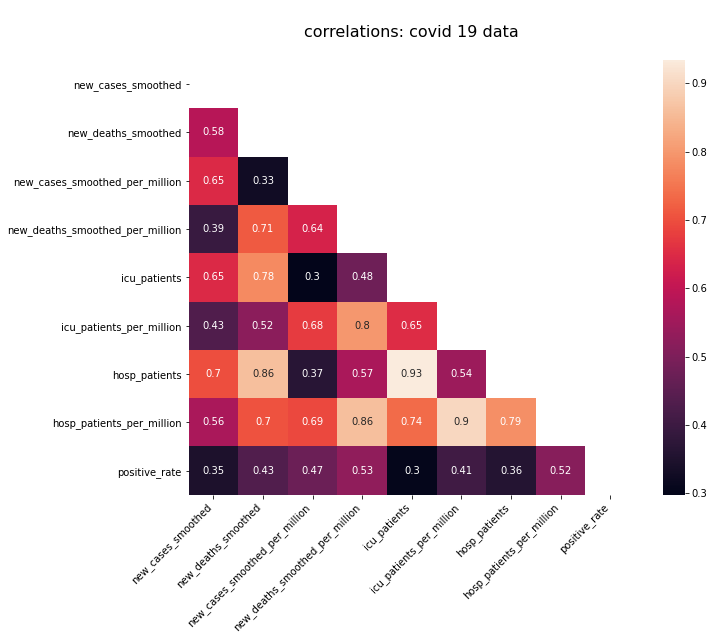

In [65]:
from pyf.eda import show_heatmap

# correlation heatmap
show_heatmap(c19_full, 10, 8, title='correlations: covid 19 data')


### 3.2.2. Google mobility data

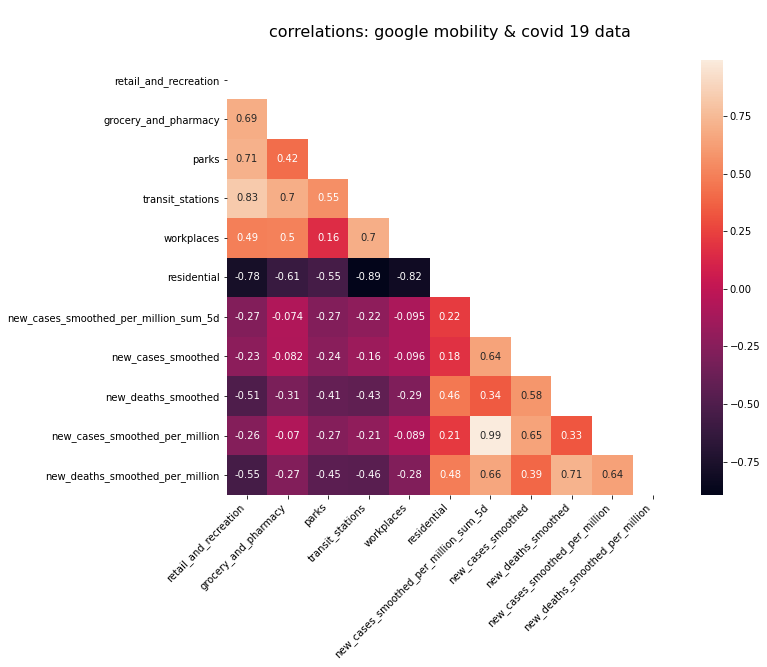

In [66]:
# correlation heatmap
show_heatmap(mobility['all_targets'], 10, 8, title='correlations: google mobility & covid 19 data')


In [67]:
# Paired density and scatterplot matrix

# pgrid_1 = sns.PairGrid(g_mob_covid, diag_sharey=False)
# pgrid_1.map_upper(sns.scatterplot, s=15)
# pgrid_1.map_lower(sns.kdeplot)
# pgrid_1.map_diag(sns.kdeplot, lw=2)

### 3.2.3. Google trends data

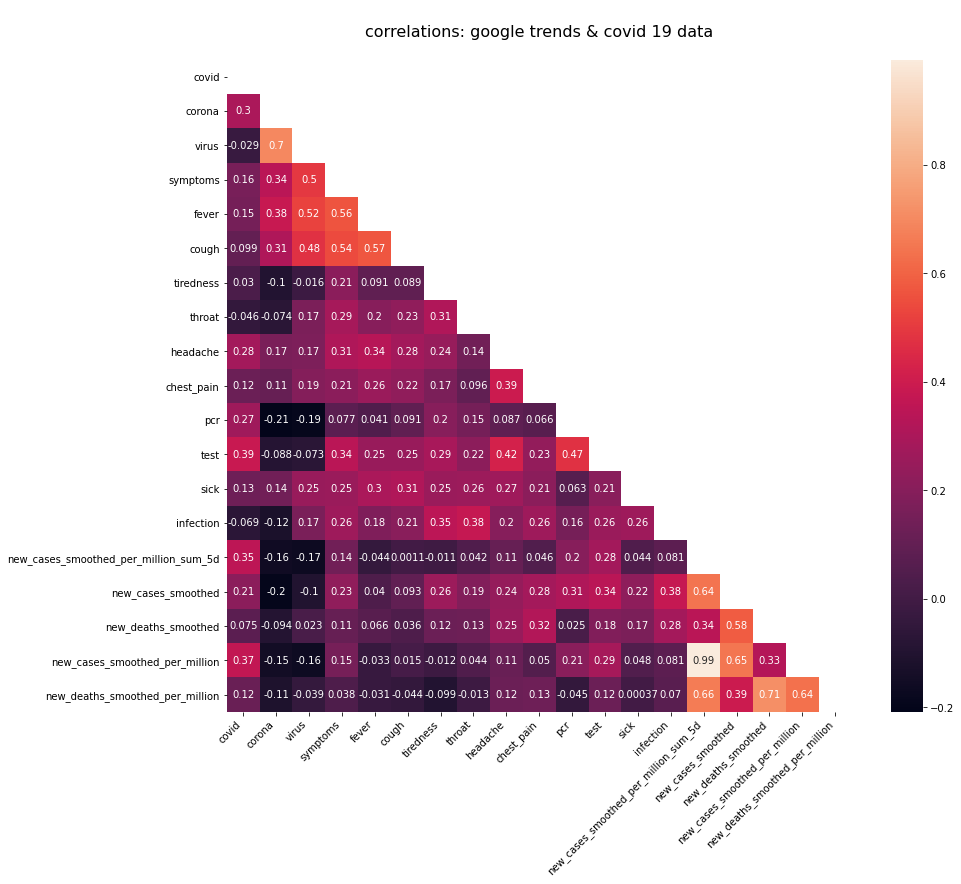

In [68]:
# correlation heatmap
show_heatmap(trends['all_targets'], 16, 14, title='correlations: google trends & covid 19 data')

### 3.3. Visual exploration

### 3.3.1. Covid 19 data

**metrics over time**

In [69]:
from pyf.eda import plot_timeseries

# dataframe with covid metrics aggregated for 13 target countries
c19_grouped_location = c19_full.drop('location', axis=1).groupby(['date']).sum()
c19_grouped_location.reset_index(inplace=True, drop=False)


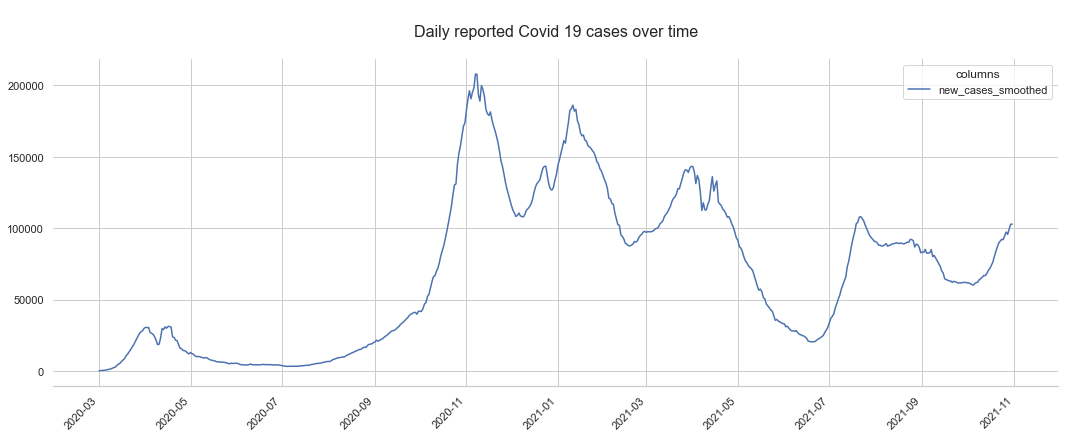

In [70]:
plot_timeseries(c19_grouped_location[['date','new_cases_smoothed']], 'date', 18, 6, 'Daily reported Covid 19 cases over time')


In [73]:
# dataframe with covid metrics averages of 13 target countries
c19_grouped_location_avg = c19_full.drop('location', axis=1).groupby(['date']).mean()
c19_grouped_location_avg = c19_grouped_location_avg.resample('W').mean()
c19_grouped_location_avg.reset_index(inplace=True, drop=False)


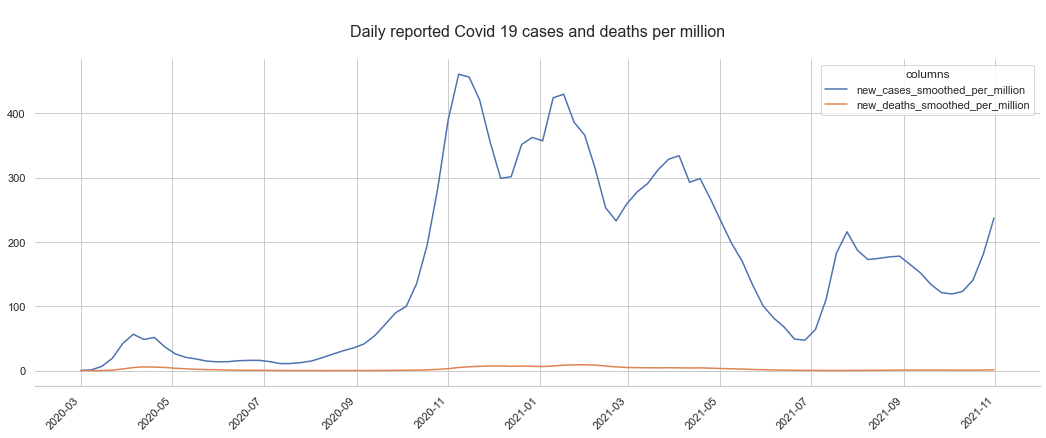

In [74]:
plot_timeseries(c19_grouped_location_avg[['date', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million']], 'date', 18, 6, 'Daily reported Covid 19 cases and deaths per million')


**time series decomposition**

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

c19_decomp = c19_full[c19_full['location'] == 'POL']

datetime_index = pd.DatetimeIndex(c19_decomp['date'].values)
c19_decomp.set_index(datetime_index, inplace=True)

decompose_data = seasonal_decompose(c19_decomp[['new_deaths_smoothed_per_million']], model="additive")


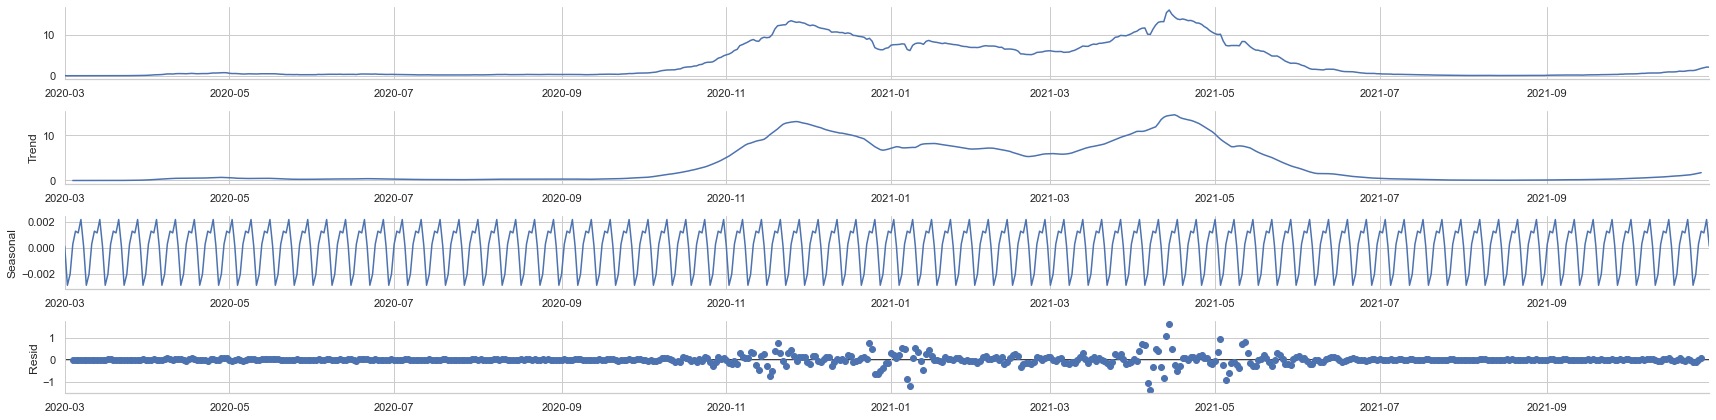

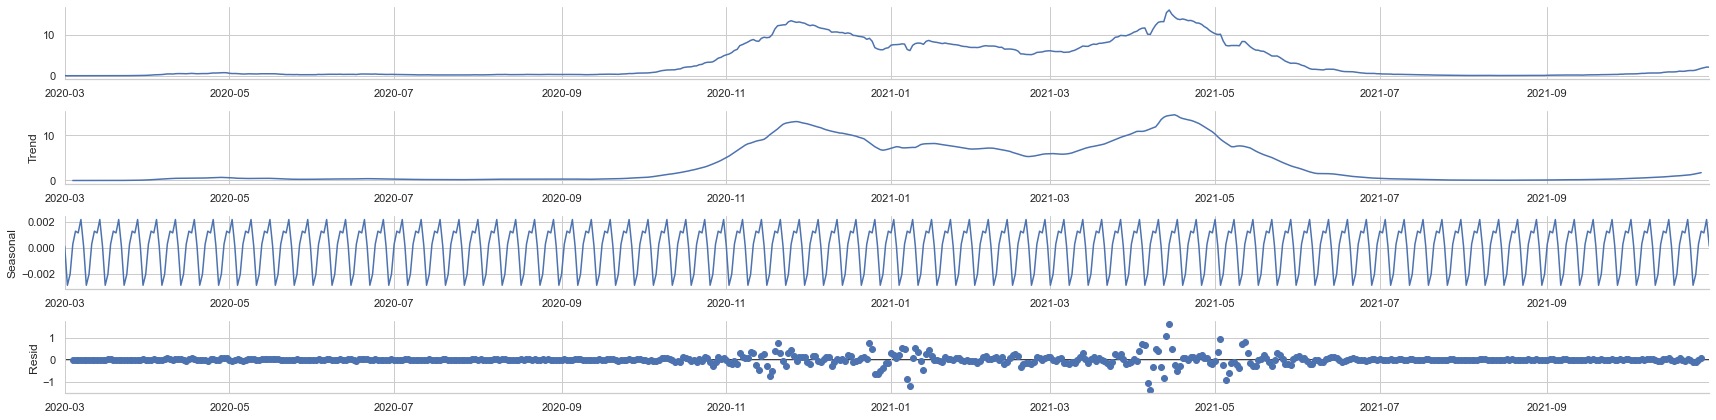

In [166]:
# plot decomposition
decompose_data.plot()


### 3.3.2. Google mobility data

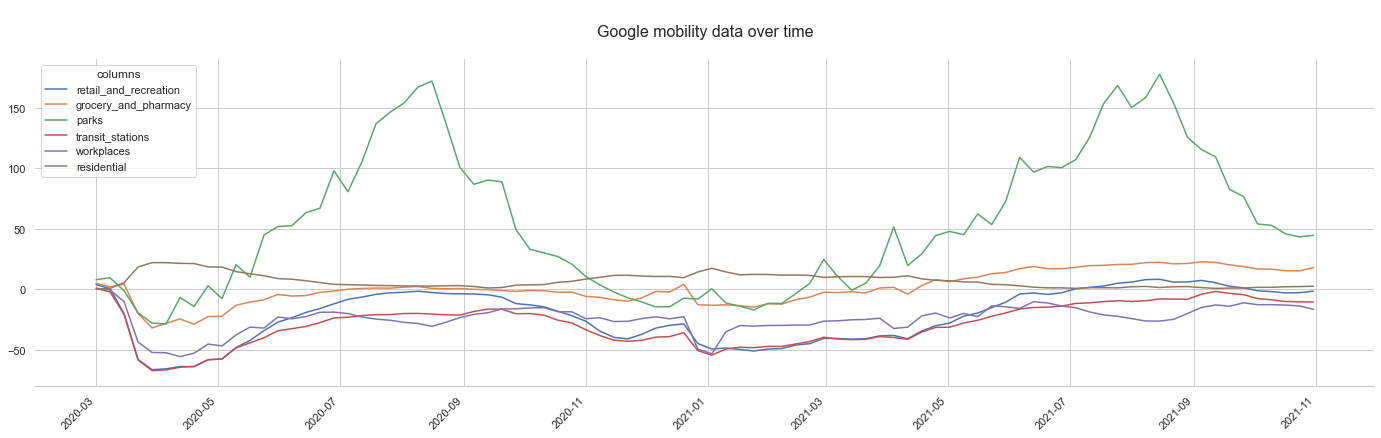

In [76]:
# dataframe with google mobility data aggregated for 13 target countries
mobility_grouped_location = data_mobility.drop('location', axis=1).groupby(['date']).mean()
mobility_grouped_location = mobility_grouped_location.resample('W').mean()
mobility_grouped_location.reset_index(inplace=True, drop=False)

plot_timeseries(mobility_grouped_location, 'date', 24, 6, 'Google mobility data over time')


### 3.3.3. Google trends data

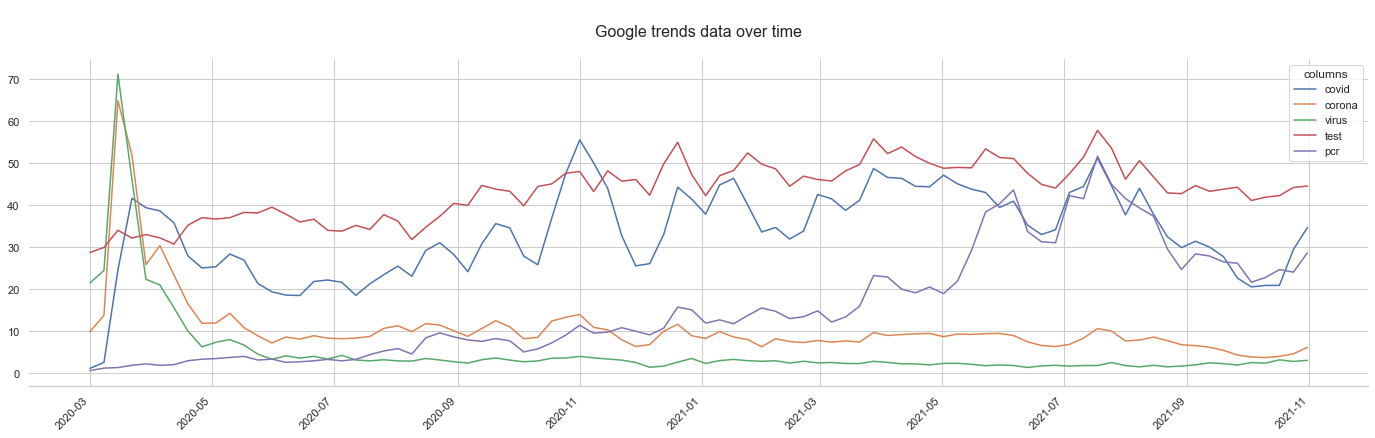

In [77]:
# dataframe with google trends data aggregated for 13 target countries
trends_grouped_location = data_g_trends.drop('location', axis=1).groupby(['date']).mean()
trends_grouped_location = trends_grouped_location.resample('W').mean()
trends_grouped_location.reset_index(inplace=True, drop=False)

plot_timeseries(trends_grouped_location[['date', 'covid', 'corona', 'virus', 'test', 'pcr']], 'date', 24, 6, 'Google trends data over time')


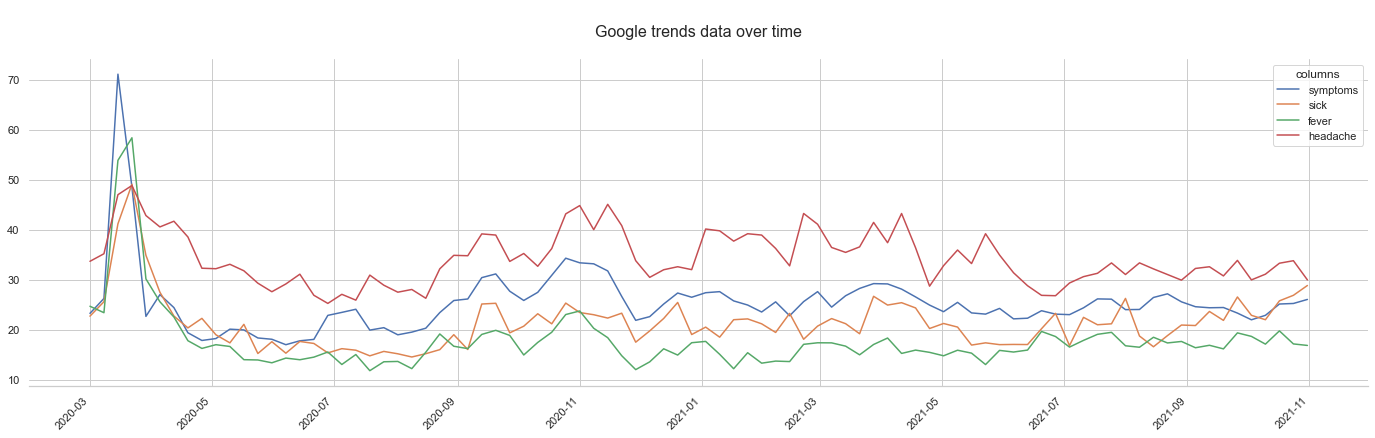

In [78]:
plot_timeseries(trends_grouped_location[['date', 'symptoms', 'sick', 'fever', 'headache']], 'date', 24, 6, 'Google trends data over time')


# 4 | Data preprocessing

### 4.1. Mobility data

### 4.1.1. Feature selection

**feature selection by correlation**

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm
from pyf.preprocessing import feature_selection_indicators
from pyf.eda import correlation_check

# overview correlation of variables above 0.8
mobility_corr = correlation_check(mobility['new_cases_smoothed_per_million'])


In [80]:
mobility_corr


,feature_1,feature_2,correlation
0,transit_stations,retail_and_recreation,0.830
1,residential,transit_stations,-0.895
2,residential,workplaces,-0.816
3,new_cases_smoothed_per_million,new_cases_smoothed_per_million_sum_5d,0.994


In [81]:
# removing col 'transit_stations'
for d in mobility.values():
    d = d.drop('transit_stations', axis=1)
    

**further feature selection**

In [85]:
# check indicators for column variance, multi colinearity (VIF) and p values 
mobility_featind = feature_selection_indicators(mobility['new_cases_smoothed_per_million'], 'new_cases_smoothed_per_million', variance_threshold=0)


In [86]:
mobility_featind

,variance,p value,VIF
const,-,0.000,9.297
retail_and_recreation,0.028192,0.000,5.177
grocery_and_pharmacy,0.005699,0.000,2.244
parks,0.022161,0.000,2.696
transit_stations,0.019697,0.765,6.994
workplaces,0.022812,0.814,4.907
residential,0.018192,0.777,11.121
new_cases_smoothed_per_million_sum_5d,0.02403,0.000,1.123


**additional selection approaches**

In [87]:
# chi2 test not neccessary because only one cat. feature


### 4.1.2. Target variable time lag

In [88]:
from pyf.preprocessing import timeseries_clustered_target_lags

# dict to store all datasets 
mobility_all = {}

# create different dfs for target variable lagging between 3 and 14 days
for target, data in mobility.items():
    if target != 'all_targets':
        mobility_all[target] = timeseries_clustered_target_lags(data, 'date', 'location', target, min_lag=3, max_lag=14)
    

In [89]:
mobility_all['new_cases_smoothed_per_million']['lag_5'].head(2)

,location,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,season,new_cases_smoothed_per_million_sum_5d,new_cases_smoothed_per_million_lag5
0,AUT,2020-03-01,0.0,8.0,6.0,1.0,2.0,0.0,spring,1.832,0.821
1,AUT,2020-03-02,2.0,6.0,16.0,1.0,3.0,-1.0,spring,1.832,1.106


### 4.1.3 encoding categorical features

In [90]:
from pyf.transform import encoding_get_dummies

# dict to store encoded datasets
mobility_encoded = mobility_all.copy()

# encoding categorical col with get dummies
for target in mobility_encoded.values():
    for lag, data in target.items():
        dataset_encoded = encoding_get_dummies(df=data, drop_first=False)
        target[lag] = dataset_encoded


In [91]:
mobility_encoded['new_cases_smoothed_per_million']['lag_5'].head(2)

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,new_cases_smoothed_per_million_sum_5d,new_cases_smoothed_per_million_lag5
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2020-03-01,0.0,8.0,6.0,1.0,2.0,0.0,1.832,0.821
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2020-03-02,2.0,6.0,16.0,1.0,3.0,-1.0,1.832,1.106


### 4.1.4. train-test-split

In [92]:
from sklearn.model_selection import train_test_split
from pyf.models import train_test_split_items

mobility_encoded_2 = mobility_encoded.copy()

# dict for all resulting dfs
mobility_modelsets = {}

# create train test splits
for target, all_lags in mobility_encoded_2.items():
    mobility_modelsets[target] = {}
    for lag, data in all_lags.items():
        mobility_modelsets[target][lag] = train_test_split_items(df=data, timeframe='date', test_size=0.2, random_state=84, as_timeseries=True)



In [93]:
mobility_modelsets['new_cases_smoothed_per_million']['lag_10']['X_test'].head(2)

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,new_cases_smoothed_per_million_sum_5d
6240,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-14.0,-8.0,61.0,-20.0,-41.0,5.0,362.236
6241,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,12.0,42.0,148.0,-2.0,-14.0,-3.0,202.134


### 4.2. Trends data

### 4.2.1. Feature selection

**feature selection by correlation**

In [94]:
# overview correlation of variables above 0.8
trends_corr = correlation_check(trends['new_cases_smoothed_per_million'])


In [95]:
trends_corr

,feature_1,feature_2,correlation
0,new_cases_smoothed_per_million,new_cases_smoothed_per_million_sum_5d,0.994


**further feature selection**

In [97]:
# check indicators for column variance, multi colinearity (VIF) and p values 
trends_featind = feature_selection_indicators(trends['new_cases_smoothed_per_million'], 'new_cases_smoothed_per_million', variance_threshold=0)


In [98]:
trends_featind

,variance,p value,VIF
const,-,0.000,11.058
covid,0.033667,0.000,1.926
corona,0.014065,0.005,3.149
virus,0.010936,0.001,3.378
symptoms,0.014323,0.000,2.086
fever,0.016112,0.324,1.962
cough,0.019872,0.000,1.791
tiredness,0.048088,0.000,1.358
throat,0.035742,0.318,1.351
headache,0.040794,0.005,1.529


**additional selection approaches**

In [99]:
# chi2 test not neccessary because only one cat. feature

### 4.2.2. Target variable time lag

In [100]:
# dict to store all datasets
trends_all = {}

# create different dfs for a lagging target variable between 3 and 14 days
for target, data in trends.items():
    if target != 'all_targets':
        trends_all[target] = timeseries_clustered_target_lags(data, 'date', 'location', target, min_lag=3, max_lag=14)
    

### 4.2.3. Encoding categorical features

In [101]:
# dict to store encoded datasets
trends_encoded = trends_all.copy()

# encoding categorical col with get dummies
for target in trends_encoded.values():
    for lag, data in target.items():
        dataset_encoded = encoding_get_dummies(df=data, drop_first=False)
        target[lag] = dataset_encoded


### 4.2.4. train-test-split

In [102]:
trends_encoded_2 = trends_encoded.copy()

# dict for all resulting dfs
trends_modelsets = {}

# create train test splits
for target, all_lags in trends_encoded_2.items():
    trends_modelsets[target] = {}
    for lag, data in all_lags.items():
        trends_modelsets[target][lag] = train_test_split_items(df=data, timeframe='date', test_size=0.2, random_state=84, as_timeseries=True)


# 5 | Baseline model

### 5.1. Baseline model using mobility data

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pyf.models import regression_model_and_evaluation, regression_model_comparison, regression_model_evaluation_metrics, regression_model_evaluation_clustered
    

In [104]:
mobility_modelsets_baseline = mobility_modelsets.copy()

# create list of model titles
rf_title_list = ['RF_cases_1M_lag' + str(d) for d in range(3,15)]

# modeling and metrics
mobility_modelsets_baseline, mobility_modelsets_baseline_comp = regression_model_comparison(datasets=mobility_modelsets_baseline['new_cases_smoothed_per_million'], titles=rf_title_list, model_type=RandomForestRegressor)


In [105]:
mobility_modelsets_baseline['lag_7']['X_test'].head(2)

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,new_cases_smoothed_per_million_sum_5d
6266,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,-4.0,21.0,142.0,8.0,-7.0,-6.0,182.960
6267,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-13.0,3.0,144.0,-8.0,8.0,-1.0,45.144


### 5.2. evaluation of mobility data baseline model 

In [106]:
mobility_modelsets_baseline_comp

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag3,0.994,0.891,0.889,33.933,49.825,2482.579
1,RF_cases_1M_lag4,0.993,0.833,0.830,42.023,61.492,3781.230
2,RF_cases_1M_lag5,0.991,0.765,0.761,50.200,73.132,5348.332
3,RF_cases_1M_lag6,0.990,0.710,0.706,56.471,81.218,6596.425
4,RF_cases_1M_lag7,0.989,0.615,0.609,65.787,93.551,8751.831
5,RF_cases_1M_lag8,0.988,0.520,0.513,74.188,104.495,10919.225
6,RF_cases_1M_lag9,0.987,0.388,0.379,85.035,117.972,13917.295
7,RF_cases_1M_lag10,0.987,0.298,0.287,92.647,126.472,15995.251
8,RF_cases_1M_lag11,0.986,0.222,0.210,96.980,133.192,17740.004
9,RF_cases_1M_lag12,0.986,0.135,0.121,102.331,140.454,19727.406


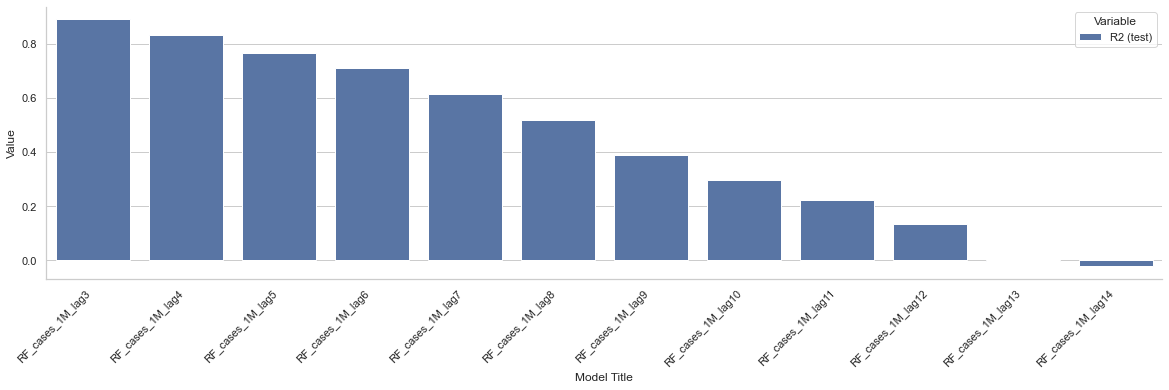

In [107]:
fig, ax1 = plt.subplots(figsize=(20, 5))
tidy = mobility_modelsets_baseline_comp.melt(id_vars='model title').rename(columns=str.title)
tidy = tidy[tidy['Variable'] == 'R2 (test)']
sns.barplot(x='Model Title', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)
plt.xticks(rotation=45, ha='right')
plt.show()

In [108]:
# get preformance metrics for 7 days lag clustered by location
baseline_by_loc = regression_model_evaluation_clustered(dataset=mobility_modelsets_baseline['lag_7'], cluster_by='location', undummify=True)


In [109]:
baseline_by_loc

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag7,GRC,0.989,-4.798,-6.248,109.434,131.767,17362.424
1,RF_cases_1M_lag7,DEU,0.989,0.169,-0.039,39.264,48.832,2384.598
2,RF_cases_1M_lag7,GBR,0.989,-1.149,-1.686,113.047,130.935,17144.076
3,RF_cases_1M_lag7,ESP,0.989,0.501,0.376,109.302,128.031,16391.812
4,RF_cases_1M_lag7,FRA,0.989,0.130,-0.087,84.975,104.686,10959.214
5,RF_cases_1M_lag7,ITA,0.989,-3.074,-4.092,50.906,57.660,3324.637
6,RF_cases_1M_lag7,NLD,0.989,-0.334,-0.668,100.110,151.164,22850.452
7,RF_cases_1M_lag7,PRT,0.989,0.026,-0.218,78.944,88.987,7918.638
8,RF_cases_1M_lag7,DNK,0.989,-0.060,-0.325,43.521,52.810,2788.851
9,RF_cases_1M_lag7,AUT,0.989,0.238,0.047,68.338,94.759,8979.278


In [110]:
# get preformance metrics for 5 days lag clustered by season
baseline_by_season = regression_model_evaluation_clustered(dataset=mobility_modelsets_baseline['lag_7'], cluster_by='season', undummify=True)

In [111]:
baseline_by_season

,model title,season,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag7,summer,0.989,0.640,0.630,59.245,94.102,8855.225
1,RF_cases_1M_lag7,fall,0.989,0.574,0.559,73.904,92.863,8623.547


<AxesSubplot:ylabel='new_cases_smoothed_per_million_lag7'>

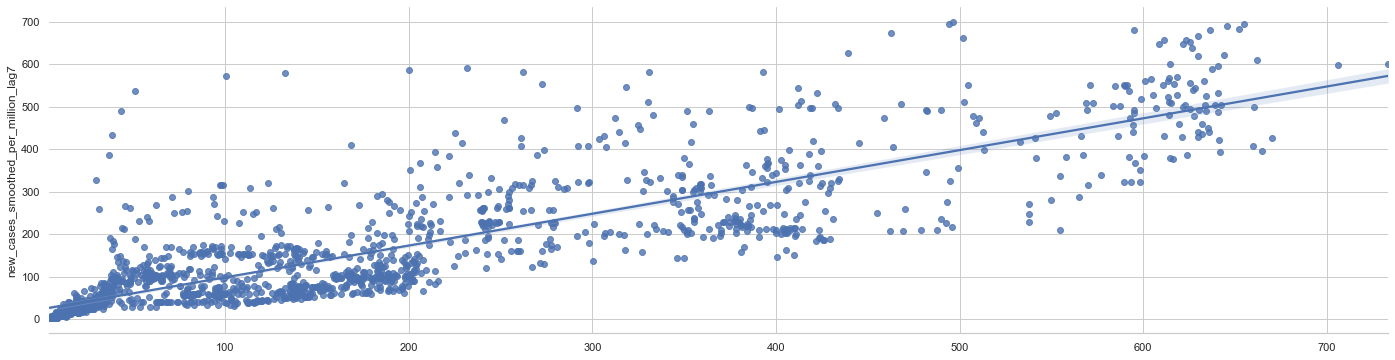

In [112]:
sns.regplot(mobility_modelsets_baseline['lag_7']['predictions'], mobility_modelsets_baseline['lag_7']['y_test'])

# 6 | Mobility data model improvements

### 6.1. Feature transformations

### 6.1.1. Feature scaling

In [113]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from pyf.transform import scaling_model_dataset, invert_scaling_model_dataset

# copy dataset for scaling
mobility_scaled = mobility_modelsets.copy()

# columns selected for scaling
mob_scale_columns = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']

for all_targets in mobility_scaled.values():
    for lag, data in all_targets.items():
        # scaling features
        data = scaling_model_dataset(dataset=data, title='minmax_x', in_columns=mob_scale_columns, transformer_type=MinMaxScaler, target=False)
        # scaling target var
        # data = scaling_model_dataset(dataset=data, title='minmax_y', transformer_type=MinMaxScaler, target=True)
        

In [114]:
# copy modelsets for Random Forest modeling
mobility_scaled_rf = mobility_scaled.copy()

# create list of model titles
rf_scaled_title_list = ['RF_cases_1M_scaled_lag' + str(d) for d in range(3,15)]        

# modeling and metrics for all targets and lags
mobility_cases_1m_scaled, mobility_cases_1m_scaled_comp = regression_model_comparison(datasets=mobility_scaled_rf['new_cases_smoothed_per_million'], titles=rf_scaled_title_list, model_type=RandomForestRegressor)


In [115]:
# performance pre scaling
mobility_modelsets_baseline_comp


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag3,0.994,0.891,0.889,33.933,49.825,2482.579
1,RF_cases_1M_lag4,0.993,0.833,0.830,42.023,61.492,3781.230
2,RF_cases_1M_lag5,0.991,0.765,0.761,50.200,73.132,5348.332
3,RF_cases_1M_lag6,0.990,0.710,0.706,56.471,81.218,6596.425
4,RF_cases_1M_lag7,0.989,0.615,0.609,65.787,93.551,8751.831
5,RF_cases_1M_lag8,0.988,0.520,0.513,74.188,104.495,10919.225
6,RF_cases_1M_lag9,0.987,0.388,0.379,85.035,117.972,13917.295
7,RF_cases_1M_lag10,0.987,0.298,0.287,92.647,126.472,15995.251
8,RF_cases_1M_lag11,0.986,0.222,0.210,96.980,133.192,17740.004
9,RF_cases_1M_lag12,0.986,0.135,0.121,102.331,140.454,19727.406


In [116]:
# performance after scaling
mobility_cases_1m_scaled_comp


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_scaled_lag3,0.994,0.889,0.887,34.454,50.183,2518.371
1,RF_cases_1M_scaled_lag4,0.992,0.838,0.836,41.534,60.677,3681.680
2,RF_cases_1M_scaled_lag5,0.991,0.763,0.759,50.533,73.505,5403.050
3,RF_cases_1M_scaled_lag6,0.990,0.705,0.700,57.192,81.951,6715.913
4,RF_cases_1M_scaled_lag7,0.989,0.622,0.616,65.043,92.770,8606.258
5,RF_cases_1M_scaled_lag8,0.988,0.527,0.520,73.746,103.738,10761.627
6,RF_cases_1M_scaled_lag9,0.986,0.430,0.421,82.105,113.835,12958.351
7,RF_cases_1M_scaled_lag10,0.986,0.305,0.294,91.904,125.901,15851.016
8,RF_cases_1M_scaled_lag11,0.986,0.264,0.252,95.912,129.521,16775.804
9,RF_cases_1M_scaled_lag12,0.985,0.090,0.076,104.675,144.020,20741.768


### 6.1.2. Boxcox transformation

In [117]:
# no boxcox because it could remove outliers, they are important

### 6.1.3. Handling outliers

In [118]:
# no outlier handeling because they are important

### 6.2. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# picking examplary data from all modelsets
mobility_cases_1m_lag5_scaled = mobility_scaled_rf['new_cases_smoothed_per_million']['lag_5'].copy()
mobility_cases_1m_lag9_scaled = mobility_scaled_rf['new_cases_smoothed_per_million']['lag_9'].copy()

# define possible parameters
params = {'max_depth': [5,9, None], 'n_estimators':[50, 100, 400], 
         'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4]}

# set up grid search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=11), params, cv=10, return_train_score=True, n_jobs=-1)



In [ ]:
# perform grid serach to find the best parameters for data with target lag 5
rf_grid_search.fit(mobility_cases_1m_lag5_scaled['X_train'], mobility_cases_1m_lag5_scaled['y_train'])

# accuracy score for best parameters
print('Best R2 score: ', rf_grid_search.best_score_)

rf_grid_search.best_params_

In [ ]:
# perform grid serach to find the best parameters for data with target lag 9
rf_grid_search.fit(mobility_cases_1m_lag9_scaled['X_train'], mobility_cases_1m_lag9_scaled['y_train'])

# accuracy score for best parameters
print('Best R2 score: ', rf_grid_search.best_score_)

rf_grid_search.best_params_


### 6.3. Alternative model algoritms

### 6.3.1. ARIMA model

To perform forecasting using the ARIMA model, we required a stationary time series. Stationary time series is a time series that is unaffected by the four components observed in the EDA. If the data is not stationary, we can either make the data stationary or use the SARIMAX model.

To know more about the time series stationarity, we can perform the ADfuller test, a test based on hypothesis, where if the p-value is less than 0.05, then we can consider the time series is stationary, or non-stationary if the p-value is greater than 0.05.

**ADfuller test**

In [119]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(c19_decomp[['new_deaths_smoothed_per_million']], autolag = 'AIC')
print("1. ADF : ",adft[0])
print("2. P-Value : ", adft[1])
print("3. Num Of Lags : ", adft[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", adft[3])
print("5. Critical Values :")
for key, val in adft[4].items():
    print("\t",key, ": ", val)


1. ADF :  -2.846451371516764
2. P-Value :  0.05193874193101481
3. Num Of Lags :  19
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 590
5. Critical Values :
	 1% :  -3.4414821678603946
	 5% :  -2.8664511716874657
	 10% :  -2.5693855271473716


Here we can see that the p-value is higher than 0.05, meaning that the evidence for the null hypothesis is low. Therefore the time series is non-stationary. 

**Data preprocessing for ARIMA model**

In [120]:
from pyf.preprocessing import model_dataset_to_datetimeindex

# country selection for arima models
arima_countries = ['ITA', 'DEU', 'CZE']

# dict for arima modeling datasets
mobility_arima = mobility_scaled.copy()
mobility_arima_by_country = {}


In [121]:
# transform model datasets to timeseries to make them compatibile with arima models
for target, targetset in mobility_arima.items():
    mobility_arima_by_country[target] = {}
    for lag, data in targetset.items():
        for c in arima_countries:
            d = data.copy()
            mobility_arima_by_country[target][lag + '_' + c] = model_dataset_to_datetimeindex(dataset=d, timeframe='date', cluster_by='location', cluster_val=c, dummyfied=True)
        

In [122]:
mobility_arima_by_country['new_cases_smoothed_per_million']['lag_7_ITA']['X_train'].head(2)

,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,new_cases_smoothed_per_million_sum_5d
2020-03-01,0,1,0,0,-19.0,-5.0,-30.0,-26.0,-5.0,4.0,26.895
2020-03-02,0,1,0,0,-13.0,-7.0,-26.0,-25.0,-9.0,5.0,26.895


**ARIMA model** 

**Finding best ARIMA model**

The auto_arima function fits the best ARIMA model to the time series data. Pyramid auto Arima performs a stepwise search for AR and MA term, meaning possible model & seasonal orders based on the chosen parameters. It selects the parameters that minimize the given metric like AIC (Akaike Information Criterion).

In [125]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from pyf.models import arima_model_and_forecast, arima_forecast_accuracy_metrics, compare_model_metrics

# df to show all model metrics
mobility_arima_metrics_all = pd.DataFrame({})

# loop through all targets and lag-location combinations:
for tgt, targetset in mobility_arima_by_country.items():
    for lag_loc, arima_modelset in targetset.items():
        
        # perform arima for lag 7 only
        if lag_loc.startswith('lag_7') == True:
        
            # finding best ARIMA model with auto_arima
            step_wise=auto_arima(arima_modelset['y_train'], exogenous= arima_modelset['X_train'], start_p=1, start_q=1, max_p=7, max_q=7, d=1, max_d=7, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
        
            # save params of best arima
            arima_params = {}
            arima_params['order'] = step_wise.get_params()['order']
        
            # perfom arima model
            arima_title = 'ARIMA ' + tgt + '_' + lag_loc
            arima_modelset = arima_model_and_forecast(dataset=arima_modelset, title=arima_title, **arima_params)
        
            # get perfomance metrics
            arima_modelset, arima_modelset_metrics = arima_forecast_accuracy_metrics(arima_modelset)
        
            # add metrics to df for all metrics
            mobility_arima_metrics_all = pd.concat([mobility_arima_metrics_all, arima_modelset_metrics], axis=0)

mobility_arima_metrics_all.reset_index(inplace=True, drop=True)
    
        

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6670.932, Time=2.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7023.952, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6690.917, Time=2.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6790.130, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7021.958, Time=1.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6693.778, Time=2.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6653.462, Time=2.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6766.219, Time=3.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6650.065, Time=3.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6650.234, Time=4.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6644.668, Time=5.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6648.041, Time=3.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6622.035, Time=4.28 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6628.304, Time=4.07 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7682.056, Time=2.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7682.575, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7684.396, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7684.440, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7680.577, Time=1.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.240 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6545.827, Time=2.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6697.886, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6590.003, Time=2.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6636.023, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6695.886, Time=1.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6543.533, Time=2.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6544.446, Time=2.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6545.291, Time=2.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6517.441, Time=3.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6544.255, Time=2.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6520.031, Time=3.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6519.663, Time=3.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6545.449, Time=3.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6527.703, Time=3.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6515.431, Time=3.05 sec
 ARIMA(1,1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3513.374, Time=2.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3779.927, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3569.993, Time=2.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3653.847, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3777.939, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3515.280, Time=3.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3515.116, Time=2.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3620.498, Time=2.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3536.452, Time=3.53 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3517.018, Time=2.87 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3510.938, Time=2.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3650.991, Time=2.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3567.972, Time=1.96 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3513.309, Time=2.50 sec
 ARIMA(1,1,2)(0,0,0)[0]          

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4287.565, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4289.270, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4285.567, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4285.929, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4287.279, Time=1.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4287.558, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4272.261, Time=2.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4229.595, Time=2.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4237.249, Time=2.85 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4230.277, Time=4.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4191.015, Time=3.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4205.529, Time=2.91 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4185.374, Time=4.05 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4113.142, Time=4.02 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4222.732, Time=4.40 sec
 ARIMA(6,1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2440.431, Time=3.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2469.523, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2455.908, Time=2.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2459.163, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2467.523, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2437.919, Time=2.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2448.023, Time=2.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2418.622, Time=3.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2416.698, Time=3.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2418.570, Time=3.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2420.623, Time=3.73 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2414.698, Time=2.65 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2446.021, Time=2.49 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2416.570, Time=3.16 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2726.516, Time=2.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3079.321, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2746.108, Time=3.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2844.449, Time=4.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3077.327, Time=2.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2749.022, Time=2.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2708.272, Time=2.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2817.359, Time=2.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2704.906, Time=3.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2705.018, Time=3.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2702.652, Time=3.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2780.702, Time=3.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2704.208, Time=3.89 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2746.293, Time=3.62 sec
 ARIMA(2,1,4)(0

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3420.755, Time=4.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3421.272, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3423.091, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3423.120, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3419.273, Time=1.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.178 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4263.448, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4415.506, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4307.588, Time=2.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4353.626, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4413.506, Time=1.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4261.103, Time=3.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4261.952, Time=2.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4262.767, Time=4.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4241.417, Time=4.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4261.857, Time=3.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4237.343, Time=3.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4171.251, Time=3.90 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4228.135, Time=3.61 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4243.260, Time=4.09 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4239.456, Time=4.28 sec
 ARIMA(3,1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-431.820, Time=2.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-164.771, Time=1.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-374.765, Time=3.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-291.066, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-166.756, Time=1.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-218.930, Time=4.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-429.616, Time=3.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-323.422, Time=2.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-408.258, Time=3.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-427.700, Time=3.99 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-433.005, Time=3.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-293.053, Time=2.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-376.822, Time=2.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-223.534, Time=3.25 sec
 ARIMA(1,1,2)(0,0,0)[0]          

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.505, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.014, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.310, Time=2.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.669, Time=3.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.025, Time=1.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26.303, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28.333, Time=3.92 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.322, Time=1.63 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.315, Time=1.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.543, Time=1.74 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22.678, Time=2.63 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26.339, Time=2.32 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 23.881 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=177.598, Time=3.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187.163, Time=0.84 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=173.822, Time=1.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=177.267, Time=2.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185.172, Time=1.86 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=165.746, Time=1.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=135.482, Time=3.78 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=137.608, Time=3.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=137.113, Time=3.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=171.742, Time=2.95 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=138.580, Time=3.82 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=133.534, Time=2.56 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=163.746, Time=1.16 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=135.600, Time=3.73 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=135.111, Time=3.30 sec
 ARIMA(2,1,1)(0,0,0)[0]  

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [126]:
mobility_arima_metrics_all

,model title,mape,corr,minmax,me,mae,mpe,rmse,acf1
0,ARIMA new_cases_smoothed_lag_7_ITA,2.062142,0.310520,0.560661,7496.533701,7496.533701,2.062142,8964.093052,0.986468
1,ARIMA new_cases_smoothed_lag_7_DEU,0.787126,0.888979,0.787123,-6178.405240,6178.559560,-0.786849,7624.370498,0.952750
2,ARIMA new_cases_smoothed_lag_7_CZE,0.496543,0.676810,0.496543,-514.175746,514.175746,-0.496543,1086.786771,0.915422
3,ARIMA new_deaths_smoothed_lag_7_ITA,0.294463,0.552329,0.262884,-6.004140,11.570052,-0.047019,14.610488,0.984152
4,ARIMA new_deaths_smoothed_lag_7_DEU,0.731137,0.822137,0.358477,4.600498,17.024178,0.541542,19.018850,0.945985
5,ARIMA new_deaths_smoothed_lag_7_CZE,1.940250,0.478013,0.451025,0.114851,2.199132,0.968755,3.434101,0.888188
6,ARIMA new_cases_smoothed_per_million_lag_7_ITA,0.585113,0.221884,0.585026,-45.616999,45.655027,-0.582148,53.503951,0.986306
7,ARIMA new_cases_smoothed_per_million_lag_7_DEU,0.787129,0.888978,0.787127,-73.639833,73.641664,-0.786854,90.874087,0.952750
8,ARIMA new_cases_smoothed_per_million_lag_7_CZE,0.379221,0.610952,0.379017,-44.486903,44.596108,-0.371870,99.559871,0.915347
9,ARIMA new_deaths_smoothed_per_million_lag_7_ITA,0.294241,0.552131,0.262847,-0.099835,0.191662,-0.047758,0.242174,0.984130


**Prediction plot**

<AxesSubplot:>

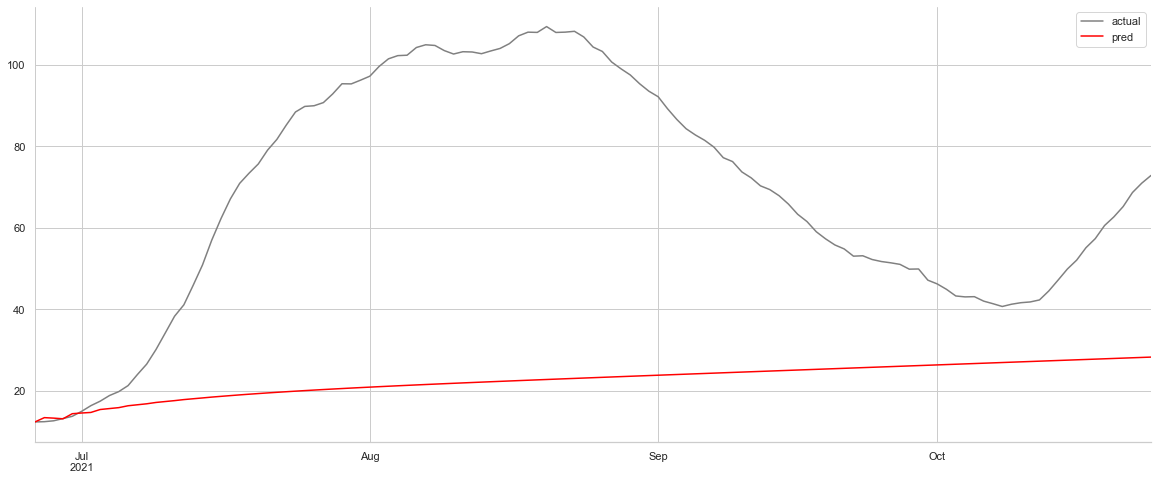

In [127]:
mobility_arima_by_country['new_cases_smoothed_per_million']['lag_7_ITA']['forecast']['actual'].plot(figsize=(20,8), legend=True, color='grey')
mobility_arima_by_country['new_cases_smoothed_per_million']['lag_7_ITA']['forecast']['pred'].plot(legend=True, color='red', figsize=(20,8))


### 6.3.2. XGBoost

In [128]:
# copy dataset for XGBoost modeling
xgb_mobility = mobility_scaled.copy()

# create list of model titles for all lags
xgb_title_list = ['XGB_cases_1M_scaled_lag' + str(d) for d in range(3,15)] # XGB_scaled_lag

# modeling and metrics for all targets and all lags 
xgb_mobility_cases_1m, xgb_mobility_cases_1m_comp = regression_model_comparison(datasets=xgb_mobility['new_cases_smoothed_per_million'], titles=xgb_title_list, model_type=XGBRegressor, random_state=11)


In [129]:
# performance metrics
xgb_mobility_cases_1m_comp


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_cases_1M_scaled_lag3,0.997,0.881,0.879,33.465,51.930,2696.720
1,XGB_cases_1M_scaled_lag4,0.997,0.826,0.823,41.164,62.794,3943.050
2,XGB_cases_1M_scaled_lag5,0.996,0.753,0.749,49.402,74.934,5615.093
3,XGB_cases_1M_scaled_lag6,0.995,0.701,0.696,55.360,82.475,6802.136
4,XGB_cases_1M_scaled_lag7,0.994,0.597,0.591,66.190,95.803,9178.159
5,XGB_cases_1M_scaled_lag8,0.994,0.520,0.513,71.446,104.457,10911.214
6,XGB_cases_1M_scaled_lag9,0.993,0.371,0.361,84.518,119.591,14302.020
7,XGB_cases_1M_scaled_lag10,0.992,0.246,0.234,94.747,131.106,17188.803
8,XGB_cases_1M_scaled_lag11,0.993,0.164,0.151,98.651,138.069,19063.178
9,XGB_cases_1M_scaled_lag12,0.991,0.104,0.090,102.784,142.923,20426.917


In [130]:
# preformance for 7 days lag by location
xgb_mobility_cases_clustered = regression_model_evaluation_clustered(dataset=xgb_mobility_cases_1m['lag_7'], cluster_by='location', undummify=True)


In [131]:
xgb_mobility_cases_clustered

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_cases_1M_scaled_lag7,GRC,0.994,-4.615,-6.019,103.323,129.674,16815.433
1,XGB_cases_1M_scaled_lag7,DEU,0.994,0.440,0.300,33.145,40.085,1606.787
2,XGB_cases_1M_scaled_lag7,GBR,0.994,-1.864,-2.580,125.110,151.138,22842.806
3,XGB_cases_1M_scaled_lag7,ESP,0.994,0.500,0.375,105.898,128.187,16431.908
4,XGB_cases_1M_scaled_lag7,FRA,0.994,0.198,-0.002,76.732,100.541,10108.544
5,XGB_cases_1M_scaled_lag7,ITA,0.994,-3.132,-4.165,53.178,58.071,3372.267
6,XGB_cases_1M_scaled_lag7,NLD,0.994,-0.241,-0.551,94.593,145.782,21252.433
7,XGB_cases_1M_scaled_lag7,PRT,0.994,-0.401,-0.751,92.572,106.713,11387.728
8,XGB_cases_1M_scaled_lag7,DNK,0.994,-0.462,-0.827,53.260,62.023,3846.860
9,XGB_cases_1M_scaled_lag7,AUT,0.994,0.307,0.134,65.229,90.400,8172.152


### 6.4. Alternative target variables

In [132]:
# create dataset dict for Random Forest and XGBoost modeling of all targets
rf_mobility_full = mobility_scaled.copy()
xgb_mobility_full = mobility_scaled.copy()

# list of target variables
mobility_modelsets_alltargets = [target for target in mobility_scaled.keys()]

# create lists of model titles
rf_alltargets_titles = ['RF_lag' + str(d) for d in range(3,15)]
xgb_alltargets_titles = ['XGB_lag' + str(d) for d in range(3,15)]

# df for comparison of target vars
rf_mobility_alltargets_metrics = pd.DataFrame({'model': rf_alltargets_titles})
xgb_mobility_alltargets_metrics = pd.DataFrame({'model': xgb_alltargets_titles})


for tgt in mobility_modelsets_alltargets:
    # RF modeling
    rf_mobility_modelset, rf_mobility_metrics = regression_model_comparison(datasets=rf_mobility_full[tgt], titles=rf_alltargets_titles, model_type=RandomForestRegressor, random_state=11)
    # copy metrics into comparison df
    rf_mobility_alltargets_metrics[tgt] = rf_mobility_metrics['R2 (test)']
    # XGBoost modeling
    xgb_mobility_modelset, xgb_mobility_metrics = regression_model_comparison(datasets=xgb_mobility_full[tgt], titles=xgb_alltargets_titles, model_type=XGBRegressor, random_state=11)
    # copy metrics into comparison df
    xgb_mobility_alltargets_metrics[tgt] = xgb_mobility_metrics['R2 (test)']


In [133]:
rf_mobility_alltargets_metrics   
    

,model,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
0,RF_lag3,0.951,-1.537,0.890,-1.885
1,RF_lag4,0.931,-2.752,0.838,-2.329
2,RF_lag5,0.902,-3.874,0.767,-2.159
3,RF_lag6,0.857,-6.777,0.703,-2.214
4,RF_lag7,0.837,-8.381,0.615,-2.479
5,RF_lag8,0.786,-11.044,0.500,-2.434
6,RF_lag9,0.739,-13.695,0.427,-3.361
7,RF_lag10,0.679,-14.154,0.333,-4.289
8,RF_lag11,0.659,-16.497,0.235,-3.953
9,RF_lag12,0.588,-17.189,0.095,-4.843


In [134]:
xgb_mobility_alltargets_metrics

,model,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
0,XGB_lag3,0.940,-2.762,0.881,-4.204
1,XGB_lag4,0.912,-1.508,0.826,-2.651
2,XGB_lag5,0.875,-5.062,0.753,-4.267
3,XGB_lag6,0.861,-4.067,0.701,-2.953
4,XGB_lag7,0.845,-5.119,0.597,-5.055
5,XGB_lag8,0.803,-7.411,0.520,-5.867
6,XGB_lag9,0.811,-8.215,0.371,-4.543
7,XGB_lag10,0.678,-11.636,0.246,-6.640
8,XGB_lag11,0.714,-10.476,0.164,-4.551
9,XGB_lag12,0.587,-17.405,0.104,-7.955


# 7 | Google trends data model

### 7.1. Random Forest model

In [135]:
trends_modelsets_rf = trends_modelsets.copy()

# create list of model titles
rf_title_list = ['RF_cases_1M_lag' + str(d) for d in range(3,15)]

# modeling and metrics
trends_modelsets_rf, trends_modelsets_rf_comp = regression_model_comparison(datasets=trends_modelsets_rf['new_cases_smoothed_per_million'], titles=rf_title_list, model_type=RandomForestRegressor)


### 7.2. Evaluation

In [136]:
trends_modelsets_rf_comp

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag3,0.995,0.908,0.906,30.236,45.808,2098.367
1,RF_cases_1M_lag4,0.994,0.870,0.867,36.328,54.327,2951.371
2,RF_cases_1M_lag5,0.993,0.831,0.827,41.912,62.083,3854.307
3,RF_cases_1M_lag6,0.992,0.781,0.776,47.967,70.661,4993.022
4,RF_cases_1M_lag7,0.991,0.730,0.724,53.999,78.438,6152.512
5,RF_cases_1M_lag8,0.989,0.665,0.658,60.066,87.277,7617.262
6,RF_cases_1M_lag9,0.989,0.598,0.590,67.419,95.592,9137.799
7,RF_cases_1M_lag10,0.987,0.553,0.544,71.552,100.945,10189.911
8,RF_cases_1M_lag11,0.987,0.475,0.464,77.610,109.366,11961.026
9,RF_cases_1M_lag12,0.986,0.415,0.403,82.575,115.449,13328.452


### 7.3. Feature transformations

### 7.3.1. Feature scaling

In [137]:
# copy dataset for scaling
trends_scaled = trends_modelsets.copy()

# columns selected for scaling
# trends_scale_columns = 




for all_targets in trends_scaled.values():
    for lag, data in all_targets.items():
        # scaling features
        data = scaling_model_dataset(dataset=data, title='minmax_x', transformer_type=MinMaxScaler, target=False)
        # scaling target var
        # data = scaling_model_dataset(dataset=data, title='minmax_y', transformer_type=MinMaxScaler, target=True)
        

In [138]:
# copy modelsets for Random Forest modeling
trends_scaled_rf = trends_scaled.copy()

# create list of model titles
rf_scaled_title_list = ['RF_cases_1M_scaled_lag' + str(d) for d in range(3,15)]        

# modeling and metrics for all targets and lags
trends_cases_1m_scaled, trends_cases_1m_scaled_comp = regression_model_comparison(datasets=trends_scaled_rf['new_cases_smoothed_per_million'], titles=rf_scaled_title_list, model_type=RandomForestRegressor)


In [139]:
# performance pre scaling
trends_modelsets_rf_comp


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag3,0.995,0.908,0.906,30.236,45.808,2098.367
1,RF_cases_1M_lag4,0.994,0.870,0.867,36.328,54.327,2951.371
2,RF_cases_1M_lag5,0.993,0.831,0.827,41.912,62.083,3854.307
3,RF_cases_1M_lag6,0.992,0.781,0.776,47.967,70.661,4993.022
4,RF_cases_1M_lag7,0.991,0.730,0.724,53.999,78.438,6152.512
5,RF_cases_1M_lag8,0.989,0.665,0.658,60.066,87.277,7617.262
6,RF_cases_1M_lag9,0.989,0.598,0.590,67.419,95.592,9137.799
7,RF_cases_1M_lag10,0.987,0.553,0.544,71.552,100.945,10189.911
8,RF_cases_1M_lag11,0.987,0.475,0.464,77.610,109.366,11961.026
9,RF_cases_1M_lag12,0.986,0.415,0.403,82.575,115.449,13328.452


In [140]:
# performance after scaling
trends_cases_1m_scaled_comp


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_scaled_lag3,0.995,0.907,0.905,30.280,45.920,2108.638
1,RF_cases_1M_scaled_lag4,0.994,0.871,0.868,35.861,54.100,2926.816
2,RF_cases_1M_scaled_lag5,0.993,0.826,0.822,42.484,62.831,3947.691
3,RF_cases_1M_scaled_lag6,0.991,0.776,0.771,48.787,71.395,5097.232
4,RF_cases_1M_scaled_lag7,0.990,0.738,0.733,53.188,77.271,5970.762
5,RF_cases_1M_scaled_lag8,0.990,0.670,0.663,60.027,86.712,7518.897
6,RF_cases_1M_scaled_lag9,0.989,0.617,0.609,65.455,93.333,8711.063
7,RF_cases_1M_scaled_lag10,0.987,0.558,0.549,71.120,100.384,10076.852
8,RF_cases_1M_scaled_lag11,0.987,0.463,0.452,78.521,110.635,12240.131
9,RF_cases_1M_scaled_lag12,0.986,0.406,0.394,83.516,116.369,13541.670


### 7.3.2. Further transformation

In [141]:
# no boxcox because it could remove outliers, they are important

In [142]:
# no outlier handeling because they are important

### 7.4. Hyperparameter tuning

In [ ]:
# picking examplary data from all modelsets
trends_cases_1m_lag5_scaled = trends_scaled_rf['new_cases_smoothed_per_million']['lag_5'].copy()
trends_cases_1m_lag9_scaled = trends_scaled_rf['new_cases_smoothed_per_million']['lag_9'].copy()

# define possible parameters
params = {'max_depth': [5,9, None], 'n_estimators':[50, 100, 400], 
         'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4]}

# set up grid search
trends_rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=11), params, cv=10, return_train_score=True, n_jobs=-1)



In [ ]:
# perform grid serach to find the best parameters for data with target lag 5
trends_rf_grid_search.fit(trends_cases_1m_lag5_scaled['X_train'], trends_cases_1m_lag5_scaled['y_train'])

# accuracy score for best parameters
print('Best R2 score: ', trends_rf_grid_search.best_score_)

trends_rf_grid_search.best_params_

In [ ]:
# perform grid serach to find the best parameters for data with target lag 9
trends_rf_grid_search.fit(trends_cases_1m_lag9_scaled['X_train'], trends_cases_1m_lag9_scaled['y_train'])

# accuracy score for best parameters
print('Best R2 score: ', trends_rf_grid_search.best_score_)

trends_rf_grid_search.best_params_


### 7.5. alternative model algoritms

### 7.5.1. ARIMA model

**Data preprocessing for ARIMA model**

In [143]:
# country selection for arima models
arima_countries = ['ITA', 'DEU', 'CZE']

# dict for arima modeling datasets
trends_arima = trends_scaled.copy()
trends_arima_by_country = {}


In [144]:
# transform model datasets to timeseries to make them compatibile with arima models
for target, targetset in trends_arima.items():
    trends_arima_by_country[target] = {}
    for lag, data in targetset.items():
        for c in arima_countries:
            d = data.copy()
            trends_arima_by_country[target][lag + '_' + c] = model_dataset_to_datetimeindex(dataset=d, timeframe='date', cluster_by='location', cluster_val=c, dummyfied=True)
        

In [145]:
trends_arima_by_country['new_cases_smoothed_per_million']['lag_7_ITA']['X_train'].head(2)

,season_fall,season_spring,season_summer,season_winter,covid,corona,virus,symptoms,fever,cough,tiredness,throat,headache,chest_pain,pcr,test,sick,infection,new_cases_smoothed_per_million_sum_5d
2020-03-01,0,1,0,0,0.7,35.88,32.64,29.70,39.69,54.75,36.72,47.57,60.68,24.20,4.68,66.96,50.4,68.73,26.895
2020-03-02,0,1,0,0,0.7,30.36,33.32,28.38,24.57,43.50,48.96,38.34,63.96,35.75,4.14,80.91,44.8,55.30,26.895


**ARIMA model**

In [146]:
# df to show all model metrics
trends_arima_metrics_all = pd.DataFrame({})

# loop through all targets and lag-location combinations:
for tgt, targetset in trends_arima_by_country.items():
    for lag_loc, arima_modelset in targetset.items():
        
        # perform arima for lag 7 only
        if lag_loc.startswith('lag_7') == True:
        
            # finding best ARIMA model with auto_arima
            step_wise=auto_arima(arima_modelset['y_train'], exogenous= arima_modelset['X_train'], start_p=1, start_q=1, max_p=7, max_q=7, d=1, max_d=7, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
        
            # save params of best arima
            arima_params = {}
            arima_params['order'] = step_wise.get_params()['order']
        
            # perfom arima model
            arima_title = 'ARIMA ' + tgt + '_' + lag_loc
            arima_modelset = arima_model_and_forecast(dataset=arima_modelset, title=arima_title, **arima_params)
        
            # get perfomance metrics
            arima_modelset, arima_modelset_metrics = arima_forecast_accuracy_metrics(arima_modelset)
        
            # add metrics to df for all metrics
            trends_arima_metrics_all = pd.concat([trends_arima_metrics_all, arima_modelset_metrics], axis=0)

trends_arima_metrics_all.reset_index(inplace=True, drop=True)
    
        

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6706.578, Time=5.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7034.483, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6720.523, Time=4.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6805.308, Time=4.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7032.498, Time=2.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6722.826, Time=6.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6681.865, Time=4.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6790.900, Time=3.78 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6681.841, Time=3.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6682.385, Time=4.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6680.847, Time=4.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6680.601, Time=4.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6768.783, Time=4.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6683.701, Time=5.00 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7688.867, Time=7.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7689.023, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7691.011, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7691.026, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7687.024, Time=3.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 11.381 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6555.452, Time=9.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6705.852, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6598.722, Time=3.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6644.413, Time=3.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6703.852, Time=2.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6551.712, Time=3.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6551.346, Time=3.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6551.934, Time=4.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6553.385, Time=4.45 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6549.347, Time=3.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6596.724, Time=2.81 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6549.941, Time=4.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6549.714, Time=3.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6553.446, Time=3.38 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6551.337, Time=3.52 sec

Best mode

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3512.107, Time=3.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3790.308, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3563.984, Time=3.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3657.001, Time=3.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3788.337, Time=1.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3514.093, Time=3.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3514.090, Time=3.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3615.920, Time=3.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3532.160, Time=3.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3516.072, Time=3.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3510.125, Time=3.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3655.009, Time=3.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3561.982, Time=2.86 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3512.089, Time=3.48 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3512.075, Time=3.38 sec
 ARIMA(0,1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4294.370, Time=3.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4294.675, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4292.375, Time=1.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4292.569, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4292.700, Time=1.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4294.338, Time=2.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4279.556, Time=3.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4232.519, Time=3.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4242.142, Time=3.80 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4233.288, Time=4.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4200.138, Time=3.97 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4205.596, Time=4.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4194.614, Time=5.07 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4194.510, Time=5.47 sec
 ARIMA(3,1,3)(0

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2446.596, Time=3.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2477.255, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2461.610, Time=3.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2465.175, Time=3.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2475.255, Time=2.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2443.809, Time=8.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2453.140, Time=7.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2426.299, Time=5.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2424.463, Time=4.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2426.214, Time=6.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2428.288, Time=6.62 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2422.463, Time=4.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2451.141, Time=4.91 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2424.215, Time=5.47 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2760.759, Time=4.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3089.851, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2775.919, Time=5.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2858.823, Time=4.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3087.866, Time=2.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2778.070, Time=3.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2734.836, Time=4.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2833.536, Time=3.61 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2732.731, Time=4.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2732.059, Time=5.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2737.274, Time=6.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2735.750, Time=6.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2712.060, Time=6.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2738.472, Time=4.80 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2736.346, Time=5.30 sec
 ARIMA(3,1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3427.772, Time=4.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3427.720, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3429.706, Time=1.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3429.708, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3425.721, Time=2.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 10.211 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4272.981, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4423.472, Time=1.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4316.295, Time=3.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4361.756, Time=5.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4421.472, Time=2.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4269.119, Time=4.88 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4268.383, Time=5.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4269.446, Time=5.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4270.709, Time=4.50 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4266.380, Time=4.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4314.300, Time=3.55 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4267.447, Time=6.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4267.111, Time=4.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4271.007, Time=3.87 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4268.709, Time=3.75 sec

Best mode

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-432.506, Time=4.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-154.389, Time=1.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-380.330, Time=6.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-286.581, Time=4.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-156.359, Time=3.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-421.017, Time=5.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-429.147, Time=4.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-326.428, Time=3.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-412.304, Time=3.56 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-427.996, Time=3.99 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-434.547, Time=3.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-289.399, Time=3.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-382.334, Time=4.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-423.517, Time=3.97 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-431.034, Time=4.17 sec
 ARIMA(0,1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=34.618, Time=4.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.427, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.123, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.321, Time=2.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.452, Time=4.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=33.086, Time=3.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35.143, Time=4.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29.150, Time=2.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31.115, Time=5.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32.650, Time=4.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.349, Time=3.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=33.140, Time=3.69 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 41.290 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=183.434, Time=4.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=194.901, Time=1.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179.381, Time=1.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=182.934, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=192.905, Time=2.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=170.891, Time=1.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=143.143, Time=3.66 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=144.102, Time=4.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=144.319, Time=4.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=176.445, Time=4.91 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=146.750, Time=4.69 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=140.947, Time=4.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=168.891, Time=2.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=142.083, Time=4.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=142.318, Time=3.64 sec
 ARIMA(2,1,1)(0,0,0)[0]  

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [147]:
trends_arima_metrics_all

,model title,mape,corr,minmax,me,mae,mpe,rmse,acf1
0,ARIMA new_cases_smoothed_lag_7_ITA,0.666921,0.000860,0.666921,-3057.613746,3057.613746,-0.666921,3516.728730,0.984884
1,ARIMA new_cases_smoothed_lag_7_DEU,0.787126,0.888979,0.787123,-6178.405240,6178.559560,-0.786849,7624.370498,0.952750
2,ARIMA new_cases_smoothed_lag_7_CZE,0.506149,0.677892,0.506149,-516.896796,516.896796,-0.506149,1088.086374,0.915417
3,ARIMA new_deaths_smoothed_lag_7_ITA,0.294463,0.552329,0.262884,-6.004140,11.570052,-0.047019,14.610488,0.984152
4,ARIMA new_deaths_smoothed_lag_7_DEU,0.787713,0.841415,0.359071,7.217749,17.406304,0.635654,19.686390,0.946083
5,ARIMA new_deaths_smoothed_lag_7_CZE,1.940250,0.478013,0.451025,0.114851,2.199132,0.968755,3.434101,0.888188
6,ARIMA new_cases_smoothed_per_million_lag_7_ITA,0.728657,0.491167,0.328864,39.408782,40.391822,0.716116,52.940042,0.992167
7,ARIMA new_cases_smoothed_per_million_lag_7_DEU,0.787129,0.888978,0.787127,-73.639833,73.641664,-0.786854,90.874087,0.952750
8,ARIMA new_cases_smoothed_per_million_lag_7_CZE,0.507581,0.678062,0.507581,-48.251925,48.251925,-0.507581,101.503059,0.915434
9,ARIMA new_deaths_smoothed_per_million_lag_7_ITA,0.294241,0.552131,0.262847,-0.099835,0.191662,-0.047758,0.242174,0.984130


**Prediction plot**

<AxesSubplot:>

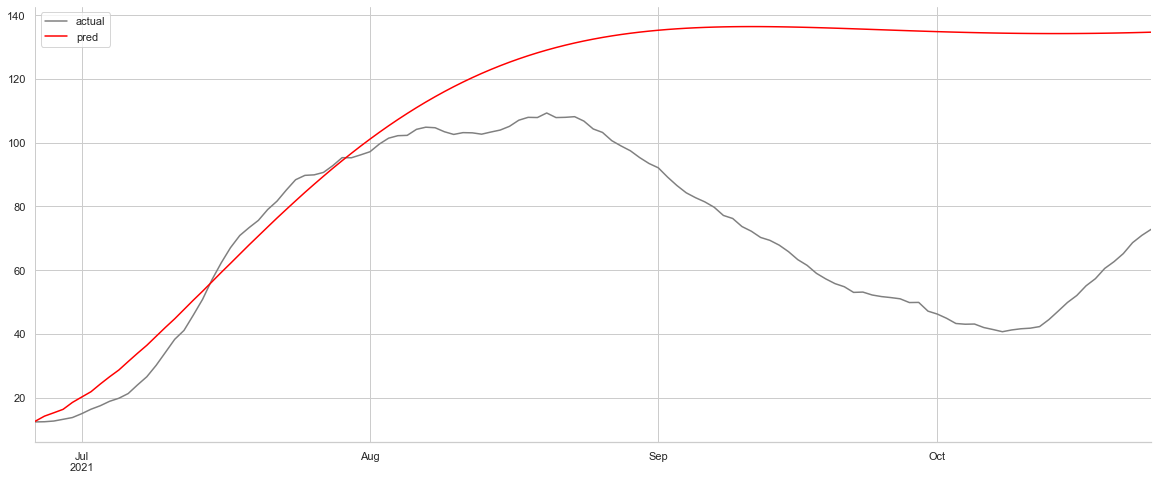

In [148]:
trends_arima_by_country['new_cases_smoothed_per_million']['lag_7_ITA']['forecast']['actual'].plot(figsize=(20,8), legend=True, color='grey')
trends_arima_by_country['new_cases_smoothed_per_million']['lag_7_ITA']['forecast']['pred'].plot(legend=True, color='red', figsize=(20,8))


### 7.5.2. XGBoost

In [149]:
# copy dataset for XGBoost modeling
xgb_trends = trends_scaled.copy()

# create list of model titles for all lags
xgb_trends_title_list = ['XGB_cases_1M_scaled_lag' + str(d) for d in range(3,15)] # XGB_scaled_lag

# modeling and metrics for all targets and all lags 
xgb_trends_cases_1m, xgb_trends_cases_1m_comp = regression_model_comparison(datasets=xgb_trends['new_cases_smoothed_per_million'], titles=xgb_trends_title_list, model_type=XGBRegressor, random_state=11)


In [150]:
# performance metrics
xgb_trends_cases_1m_comp


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_cases_1M_scaled_lag3,0.999,0.908,0.906,29.444,45.740,2092.153
1,XGB_cases_1M_scaled_lag4,0.999,0.862,0.859,36.608,56.050,3141.573
2,XGB_cases_1M_scaled_lag5,0.998,0.821,0.817,41.975,63.894,4082.432
3,XGB_cases_1M_scaled_lag6,0.997,0.791,0.787,46.450,68.970,4756.902
4,XGB_cases_1M_scaled_lag7,0.997,0.741,0.736,51.704,76.809,5899.618
5,XGB_cases_1M_scaled_lag8,0.997,0.672,0.665,58.517,86.411,7466.834
6,XGB_cases_1M_scaled_lag9,0.996,0.581,0.572,67.616,97.625,9530.723
7,XGB_cases_1M_scaled_lag10,0.996,0.586,0.577,69.048,97.208,9449.342
8,XGB_cases_1M_scaled_lag11,0.995,0.496,0.485,77.181,107.166,11484.594
9,XGB_cases_1M_scaled_lag12,0.995,0.453,0.442,81.180,111.692,12475.052


In [151]:
# preformance for 7 days lag by location
xgb_trends_cases_clustered = regression_model_evaluation_clustered(dataset=xgb_trends_cases_1m['lag_7'], cluster_by='location', undummify=True)


In [152]:
xgb_trends_cases_clustered

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_cases_1M_scaled_lag7,AUT,0.997,0.757,0.669,42.797,53.508,2863.151
1,XGB_cases_1M_scaled_lag7,FRA,0.997,0.329,0.085,73.085,91.914,8448.203
2,XGB_cases_1M_scaled_lag7,NLD,0.997,-0.112,-0.516,92.093,138.024,19050.702
3,XGB_cases_1M_scaled_lag7,GRC,0.997,-1.170,-1.959,66.281,80.621,6499.670
4,XGB_cases_1M_scaled_lag7,POL,0.997,0.952,0.935,6.968,9.246,85.496
5,XGB_cases_1M_scaled_lag7,CZE,0.997,0.728,0.629,23.947,46.821,2192.168
6,XGB_cases_1M_scaled_lag7,DEU,0.997,0.424,0.215,32.640,40.660,1653.202
7,XGB_cases_1M_scaled_lag7,PRT,0.997,0.481,0.292,50.382,64.961,4219.883
8,XGB_cases_1M_scaled_lag7,DNK,0.997,-0.117,-0.523,44.422,54.224,2940.267
9,XGB_cases_1M_scaled_lag7,GBR,0.997,-0.595,-1.175,88.435,112.784,12720.145


### 7.6. Alternative target variables

In [153]:
# create dataset dict for Random Forest and XGBoost modeling of all targets
rf_trends_full = trends_scaled.copy()
xgb_trends_full = trends_scaled.copy()

# list of target variables
trends_modelsets_alltargets = [target for target in mobility_scaled.keys()]

# create lists of model titles
rf_alltargets_titles = ['RF_lag' + str(d) for d in range(3,15)]
xgb_alltargets_titles = ['XGB_lag' + str(d) for d in range(3,15)]

# df for comparison of target vars
rf_trends_alltargets_metrics = pd.DataFrame({'model': rf_alltargets_titles})
xgb_trends_alltargets_metrics = pd.DataFrame({'model': xgb_alltargets_titles})


for tgt in trends_modelsets_alltargets:
    # RF modeling
    rf_trends_modelset, rf_trends_metrics = regression_model_comparison(datasets=rf_trends_full[tgt], titles=rf_alltargets_titles, model_type=RandomForestRegressor, random_state=11)
    # copy metrics into comparison df
    rf_trends_alltargets_metrics[tgt] = rf_trends_metrics['R2 (test)']
    # XGBoost modeling
    xgb_trends_modelset, xgb_trends_metrics = regression_model_comparison(datasets=xgb_trends_full[tgt], titles=xgb_alltargets_titles, model_type=XGBRegressor, random_state=11)
    # copy metrics into comparison df
    xgb_trends_alltargets_metrics[tgt] = xgb_trends_metrics['R2 (test)']


In [154]:
rf_trends_alltargets_metrics   
    

,model,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
0,RF_lag3,0.937,-10.185,0.908,-16.786
1,RF_lag4,0.926,-10.153,0.872,-17.458
2,RF_lag5,0.912,-12.536,0.822,-18.649
3,RF_lag6,0.897,-13.958,0.780,-17.175
4,RF_lag7,0.876,-17.999,0.732,-16.875
5,RF_lag8,0.859,-24.222,0.669,-15.371
6,RF_lag9,0.832,-23.595,0.603,-14.780
7,RF_lag10,0.813,-25.262,0.546,-13.379
8,RF_lag11,0.794,-25.895,0.474,-12.617
9,RF_lag12,0.783,-24.656,0.399,-12.508


In [155]:
xgb_trends_alltargets_metrics

,model,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
0,XGB_lag3,0.949,-10.376,0.908,-10.736
1,XGB_lag4,0.931,-12.874,0.862,-12.744
2,XGB_lag5,0.914,-16.307,0.821,-15.193
3,XGB_lag6,0.895,-22.427,0.791,-13.038
4,XGB_lag7,0.865,-20.952,0.741,-13.551
5,XGB_lag8,0.850,-22.178,0.672,-11.839
6,XGB_lag9,0.827,-22.282,0.581,-11.742
7,XGB_lag10,0.815,-22.243,0.586,-10.519
8,XGB_lag11,0.801,-25.369,0.496,-11.227
9,XGB_lag12,0.779,-23.243,0.453,-10.553


# 8 | Model insights

### 8.1. Comparing models

### 8.1.1. Overall performance

In [170]:
#comparing the performance of all regression models with lag 7 for all targets
lag7_list = [rf_mobility_alltargets_metrics, xgb_mobility_alltargets_metrics, rf_trends_alltargets_metrics, xgb_trends_alltargets_metrics]

lag7_comp = pd.DataFrame({})

for ov in lag7_list:
    lag7_row = ov[ov.index == 4]
    lag7_comp = pd.concat([lag7_comp, lag7_row], axis=0)
    

In [171]:
lag7_comp

,model,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
4,RF_lag7,0.837,-8.381,0.615,-2.479
4,XGB_lag7,0.845,-5.119,0.597,-5.055
4,RF_lag7,0.876,-17.999,0.732,-16.875
4,XGB_lag7,0.865,-20.952,0.741,-13.551


In [172]:
for c in lag7_comp.select_dtypes(np.number).columns:
    print(c, ': ', lag7_comp[c].mean())

new_cases_smoothed :  0.85575
new_deaths_smoothed :  -13.11275
new_cases_smoothed_per_million :  0.67125
new_deaths_smoothed_per_million :  -9.49


### 8.1.2. Performance on a country level

In [ ]:
# get preformance metrics for 7 days lag clustered by location
baseline_by_loc = regression_model_evaluation_clustered(dataset=mobility_modelsets_baseline['lag_7'], cluster_by='location', undummify=True)

In [174]:
baseline_by_loc

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_1M_lag7,GRC,0.989,-4.798,-6.248,109.434,131.767,17362.424
1,RF_cases_1M_lag7,DEU,0.989,0.169,-0.039,39.264,48.832,2384.598
2,RF_cases_1M_lag7,GBR,0.989,-1.149,-1.686,113.047,130.935,17144.076
3,RF_cases_1M_lag7,ESP,0.989,0.501,0.376,109.302,128.031,16391.812
4,RF_cases_1M_lag7,FRA,0.989,0.130,-0.087,84.975,104.686,10959.214
5,RF_cases_1M_lag7,ITA,0.989,-3.074,-4.092,50.906,57.660,3324.637
6,RF_cases_1M_lag7,NLD,0.989,-0.334,-0.668,100.110,151.164,22850.452
7,RF_cases_1M_lag7,PRT,0.989,0.026,-0.218,78.944,88.987,7918.638
8,RF_cases_1M_lag7,DNK,0.989,-0.060,-0.325,43.521,52.810,2788.851
9,RF_cases_1M_lag7,AUT,0.989,0.238,0.047,68.338,94.759,8979.278


In [186]:
percountry_test = regression_model_evaluation_clustered(dataset=rf_trends_full['new_cases_smoothed']['lag_7'], cluster_by='location', undummify=True)

In [188]:
percountry_test

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_lag7,AUT,0.998,0.260,-0.009,575.174,844.520,7.132135e+05
1,XGB_lag7,FRA,0.998,0.506,0.326,4078.851,5329.747,2.840620e+07
2,XGB_lag7,NLD,0.998,-1.275,-2.102,2557.032,3389.915,1.149152e+07
3,XGB_lag7,GRC,0.998,-0.969,-1.685,642.932,796.305,6.341021e+05
4,XGB_lag7,POL,0.998,0.662,0.539,630.508,926.616,8.586171e+05
5,XGB_lag7,CZE,0.998,-0.566,-1.135,679.452,1205.768,1.453876e+06
6,XGB_lag7,DEU,0.998,0.595,0.448,2107.065,2860.875,8.184605e+06
7,XGB_lag7,PRT,0.998,-5.899,-8.408,1477.159,2407.868,5.797829e+06
8,XGB_lag7,DNK,0.998,-8.739,-12.280,615.832,930.753,8.663016e+05
9,XGB_lag7,GBR,0.998,-1.060,-1.809,6834.330,8742.018,7.642288e+07


In [190]:
# getting the average performance of all models for daily new cases for every target country at lag 7

lag7_by_country_list = [rf_mobility_full, xgb_mobility_full, rf_trends_full, xgb_trends_full]

lag7_by_country_avg = pd.DataFrame({})

# loop through metrics dfs
for m in lag7_by_country_list:
    # metrics for one model
    la7_by_coutry_metrics = regression_model_evaluation_clustered(dataset=m['new_cases_smoothed']['lag_7'], cluster_by='location', undummify=True)
    
    # concat with aggregate df
    lag7_by_country_avg = pd.concat([lag7_by_country_avg, la7_by_coutry_metrics], axis=0)
    
# transform df to average values
lag7_by_country_avg = lag7_by_country_avg.drop(['model title'], axis=1).groupby(['location']).mean()
 

In [193]:
lag7_by_country_avg.sort_values(by='R2 (test)', ascending=False)

,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
location,,,,,,
POL,0.997,0.7910,0.7195,452.6575,689.2455,5.314042e+05
ESP,0.997,0.5945,0.4735,4200.5540,5385.1425,2.913658e+07
DEU,0.997,0.4650,0.3085,2560.9365,3263.0925,1.080955e+07
FRA,0.997,0.4345,0.2650,4333.3480,5690.5400,3.251242e+07
AUT,0.997,0.1820,-0.0645,593.2940,886.9580,7.884949e+05
CZE,0.997,0.1250,-0.1825,456.6080,809.5320,8.123448e+05
NLD,0.997,-0.7765,-1.3500,2075.3300,2965.0945,8.972255e+06
GBR,0.997,-1.2105,-1.8800,6953.8075,9051.2470,8.202069e+07
ITA,0.997,-1.4285,-2.1130,2261.5835,2618.1510,7.223629e+06
